In [1]:
# Import libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [2]:
data = pd.read_csv('cov_merged.csv')
target = pd.read_csv('outcomes.csv')
print(data)
print(target)

            rowId  covariateId  covariateValue  \
0          3938.0   4083311102               1   
1        175397.0     81380102               1   
2         23031.0   4145418102               1   
3        152472.0    135473102               1   
4         60021.0   4213101102               1   
...           ...          ...             ...   
5411125   67932.0    378253104               1   
5411126  135007.0   4211852104               1   
5411127  127381.0    197988104               1   
5411128   20208.0    201826104               1   
5411129  161935.0    440005104               1   

                                             covariateName  analysisId  \
0        condition_occurrence during day -365 through -...         102   
1        condition_occurrence during day -365 through -...         102   
2        condition_occurrence during day -365 through -...         102   
3        condition_occurrence during day -365 through -...         102   
4        condition_occurrence

In [3]:
ancestry = pd.read_csv("relations_ancestor_total.csv")
print(ancestry)

          Unnamed: 0  ANCESTOR_CONCEPT_ID  DESCENDANT_CONCEPT_ID  \
0                  1                262.0                  262.0   
1                  2                263.0                  263.0   
2                  3                264.0                  264.0   
3                  4                265.0                  265.0   
4                  5                266.0                  266.0   
...              ...                  ...                    ...   
78195440    78195441           46369493.0             46369493.0   
78195441    78195442           46369844.0             46369844.0   
78195442    78195443           46369845.0             46369845.0   
78195443    78195444           46369901.0             46369901.0   
78195444    78195445           46369902.0             46369902.0   

          MIN_LEVELS_OF_SEPARATION  MAX_LEVELS_OF_SEPARATION         CTID  
0                                0                         0        (0,1)  
1                              

In [4]:
# Get the concept and analysis id from the covariate id
data_concepts = []
windows = []
for i in data['covariateId']:
    concept = i // 1000
    window = i % 1000
    data_concepts.append(concept)
    windows.append(window)

# Create windows to represent analysis ids
analysisId_to_window = {101: "all", 102: '365d', 103: '180d', 104: '030d', 105: 'all',
                        106: '365d', 107: '180d', 108: '030d'}

# Create observations data file from data file
observation = pd.DataFrame()
observation['conceptId'] = data_concepts
observation['analysisId'] = windows
observation['window'] = observation['analysisId'].apply(lambda x: analysisId_to_window.get(x, 'Unknown'))
observation['covariateValue'] = 1
observation['patient'] = data['rowId'].astype(int)
print(observation)

         conceptId  analysisId window  covariateValue  patient
0          4083311         102   365d               1     3938
1            81380         102   365d               1   175397
2          4145418         102   365d               1    23031
3           135473         102   365d               1   152472
4          4213101         102   365d               1    60021
...            ...         ...    ...             ...      ...
5411125     378253         104   030d               1    67932
5411126    4211852         104   030d               1   135007
5411127     197988         104   030d               1   127381
5411128     201826         104   030d               1    20208
5411129     440005         104   030d               1   161935

[5411130 rows x 5 columns]


In [5]:
observation_all = observation[observation['window'] == "all"]
print(len(observation_all))
observation_365d = observation[observation['window'] == "365d"]
print(len(observation_365d))
observation_180d = observation[observation['window'] == "180d"]
print(len(observation_180d))
observation_030d = observation[observation['window'] == "030d"]
print(len(observation_030d))

# Pick time window
chosen_window = "365d"
observation = observation[observation['window'] == chosen_window]
observation = observation.drop_duplicates(subset=['conceptId', 'patient'])

4257791
656937
385185
111217


In [6]:
def pivot_covariates(df):
    observation = df.pivot(index='patient', columns='conceptId', values='covariateValue')
    return observation.fillna(0)

observation_wide = pivot_covariates(observation)

In [7]:
risk_window_end = 1825
def create_outcomes(indexes):
    outcomes = []
    for i in indexes:
        if i in target['rowId'].values:
            days_to_event = target.loc[target['rowId'] == i, 'daysToEvent'].values[0]
            outcomes.append(1 if days_to_event < risk_window_end else 0)
        else:
            outcomes.append(0)
    return outcomes

outcomes = create_outcomes(observation_wide.index)

In [8]:
patients = observation['patient']
observed_concepts = set(observation_wide.columns)

print(patients)
print(observation_wide)
print(outcomes)
print(len(observed_concepts))

0           3938
1         175397
2          23031
3         152472
4          60021
           ...  
650530    161935
650531     76731
650532    171895
650533     37081
650534    153296
Name: patient, Length: 650535, dtype: int32
conceptId  22281     23325     24609     24660     24966     25297     \
patient                                                                 
1               0.0       0.0       0.0       0.0       0.0       0.0   
2               0.0       0.0       0.0       0.0       0.0       0.0   
3               0.0       0.0       0.0       0.0       0.0       0.0   
4               0.0       0.0       0.0       0.0       0.0       0.0   
5               0.0       0.0       0.0       0.0       0.0       0.0   
...             ...       ...       ...       ...       ...       ...   
176489          0.0       0.0       0.0       0.0       0.0       0.0   
176490          0.0       0.0       0.0       0.0       0.0       0.0   
176491          0.0       0.0       0.0

In [9]:
random_state = 42
test_size = 0.25
# Split the data in train and test set
observations_train, observations_test, outcomes_train, outcomes_test = train_test_split(observation_wide, outcomes, stratify=outcomes, random_state=random_state, test_size=test_size)

In [10]:
patients_train = list(observations_train.index)
patients_test = list(observations_test.index)
print(len(patients_train))
print(len(patients_test))

115038
38347


In [11]:
target_train = target[target['rowId'].isin(patients_train)]
target_test = target[target['rowId'].isin(patients_test)]
print(len(target_train))
print(len(target_test))

302
95


In [12]:
observed_concepts_train = set(observations_train.columns)
observed_concepts_test = set(observations_test.columns)
print(len(observed_concepts_train))
print(len(observed_concepts_test))

1368
1368


In [13]:
# Choose what level above the data stays
chosen_level = 4
# Filter relations above chosen level
filtered_relations = ancestry[
    (ancestry['ANCESTOR_CONCEPT_ID'] == 441840) &
    (ancestry['MIN_LEVELS_OF_SEPARATION'] < chosen_level)
]

print(filtered_relations)
print(len(set(filtered_relations['DESCENDANT_CONCEPT_ID'])))

        Unnamed: 0  ANCESTOR_CONCEPT_ID  DESCENDANT_CONCEPT_ID  \
517810      517811             441840.0             45765959.0   
517811      517812             441840.0              4151309.0   
517813      517814             441840.0             42535668.0   
517816      517817             441840.0              4095355.0   
517821      517822             441840.0              4036777.0   
...            ...                  ...                    ...   
645041      645042             441840.0              4059280.0   
645046      645047             441840.0              4083769.0   
645047      645048             441840.0              4341796.0   
645050      645051             441840.0              4338249.0   
645051      645052             441840.0              4281541.0   

        MIN_LEVELS_OF_SEPARATION  MAX_LEVELS_OF_SEPARATION        CTID  
517810                         3                         3  (2798,181)  
517811                         2                         2  (

In [14]:
selected_concepts = set(filtered_relations['DESCENDANT_CONCEPT_ID'])
print(len(set(selected_concepts)))
selected_observed_concepts = selected_concepts & set(observation_wide.columns)
print(len(set(selected_observed_concepts)))

17829
323


In [15]:
print(441840.0 in selected_concepts)

True


In [16]:
observed_concepts_ancestors = ancestry[ancestry['DESCENDANT_CONCEPT_ID'].isin(observed_concepts)]['ANCESTOR_CONCEPT_ID']
features = set(observed_concepts_ancestors) & selected_concepts
print(len(features))


1228


In [17]:
data_train = pd.DataFrame(0, index=patients_train, columns=list(features))
data_test = pd.DataFrame(0, index=patients_test, columns=list(features))
observations_train_wide = observations_train
observations_test_wide = observations_test
print(data_train)

        4087808.0   4206592.0   40488964.0  4087814.0   4087818.0   \
50529            0           0           0           0           0   
19113            0           0           0           0           0   
36311            0           0           0           0           0   
26132            0           0           0           0           0   
163264           0           0           0           0           0   
...            ...         ...         ...         ...         ...   
12906            0           0           0           0           0   
56633            0           0           0           0           0   
50522            0           0           0           0           0   
152310           0           0           0           0           0   
129118           0           0           0           0           0   

        4182027.0   45768719.0  4040720.0   42539027.0  4304916.0   ...  \
50529            0           0           0           0           0  ...   
19113    

In [18]:
selected_observed_concepts_train = selected_concepts & set(observations_train_wide.columns)
print(len(set(selected_observed_concepts)))
selected_observed_concepts_test = selected_concepts & set(observations_test_wide.columns)
print(len(set(selected_observed_concepts)))

323
323


In [19]:
print(441840.0 in features)

True


In [20]:
for concept in observed_concepts_train:
    observed_concept_train_ancestors = ancestry[ancestry['DESCENDANT_CONCEPT_ID'] == concept]['ANCESTOR_CONCEPT_ID']
    features_for_concept = set(observed_concept_train_ancestors) & features
    print(observed_concept_train_ancestors)
    print(features_for_concept)
    for feature in features_for_concept:
        data_train[feature] += observations_train_wide[concept]
print(data_train)

348055        432250.0
360235        432545.0
401089        434557.0
471004        439719.0
496077        440631.0
554022        441840.0
11766695     4112387.0
15117399     4274025.0
38971329    36715956.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 432545.0, 432250.0, 4274025.0}
17834          73754.0
73671         133468.0
122190        138239.0
162683        193460.0
418992        435524.0
475694        440087.0
556281        441840.0
716407        444108.0
9215598      4022922.0
10261768     4041283.0
15131640     4274025.0
29344075    35626941.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041283.0, 435524.0, 4274025.0, 4022922.0, 444108.0, 441840.0, 193460.0, 440087.0, 133468.0, 138239.0}
2393          24609.0
4628          30361.0
6753          31821.0
433609       436670.0
442316       437515.0
525735       441840.0
12221322    4130161.0
13522343    4180628.0
15105303    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 437515.0, 31821.0, 441840.0, 418062

180978        196738.0
576159        441840.0
9422900      4028071.0
10278953     4041285.0
11479662     4090861.0
11694973     4104157.0
11859783     4117930.0
13123550     4171379.0
13338230     4179871.0
13529013     4180628.0
13684296     4181194.0
15132913     4274025.0
41215682    37311677.0
41229953    37311678.0
51706701    43531053.0
51743930    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041285.0, 4028071.0, 4274025.0, 4117930.0, 441840.0, 4171379.0, 4180628.0, 43531059.0, 37311677.0, 37311678.0}
240385        255919.0
279345        373499.0
290157        375252.0
331986        376965.0
338772        378416.0
606550        441840.0
9405187      4027883.0
9856960      4038502.0
10589417     4042836.0
11315473     4080992.0
12339780     4134440.0
12785882     4162092.0
13541658     4180628.0
14210294     4209989.0
14820885     4247371.0
15141800     4274025.0
48840030    42709887.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 376965.0, 4038502.0, 4134440.0, 

551632       441840.0
655462       442562.0
15114973    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 442562.0}
364913        432586.0
385059        432876.0
433138        436665.0
517747        441836.0
586037        441840.0
658271        442570.0
715847        444100.0
12609177     4154283.0
12652792     4155798.0
14082287     4200385.0
15137209     4274025.0
50205584    42872413.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
15019          73553.0
18944          74124.0
50166          77960.0
73715         133468.0
105417        135930.0
125558        138239.0
163350        193460.0
219468        253549.0
311645        376208.0
374247        432795.0
502020        440921.0
574155        441840.0
659731        442628.0
728500        444132.0
9176890      4022201.0
9216777      4022922.0
9221613      4022923.0
11103002     4054054.0
11359068     4083964.0
11540675     4093991.0
11557211     4094284.0
11636517     4100

151664        141960.0
199925        200174.0
319385        376208.0
628437        441840.0
724214        444112.0
9465321      4028387.0
11355493     4083787.0
11547920     4093991.0
12495065     4145436.0
13560795     4180628.0
14255209     4212577.0
15171868     4274025.0
15853695     4316083.0
15861510     4317258.0
16279918     4344497.0
40159958    37018424.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4212577.0, 4028387.0, 4093991.0, 141960.0, 4274025.0, 4317258.0, 4083787.0, 200174.0, 444112.0, 376208.0, 441840.0, 4344497.0, 4180628.0, 37018424.0}
84113         134057.0
257602        318549.0
264604        321588.0
400345        434462.0
476231        440142.0
527818        441840.0
9246505      4023995.0
9342022      4027255.0
9416239      4028071.0
10814639     4043346.0
11669844     4103183.0
11820609     4115390.0
11853572     4117930.0
12842581     4166245.0
13511438     4180628.0
13818837     4185503.0
14485501     4227253.0
15113150     4274025.0
43362948    40457757.0
51

507505        440985.0
514860        441542.0
533749        441840.0
9006639      4012101.0
9168148      4021782.0
9301569      4025215.0
9675811      4029621.0
11366833     4084717.0
11368417     4085063.0
11781541     4113821.0
15028974     4269314.0
15317855     4293175.0
38975294    36716893.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4269314.0, 4025215.0, 4293175.0}
507571        440985.0
515010        441542.0
595817        441840.0
9006650      4012101.0
9168260      4021782.0
9301930      4025215.0
9675892      4029621.0
11366845     4084717.0
11368435     4085063.0
11781581     4113821.0
12451350     4142502.0
15030036     4269314.0
15320314     4293175.0
38975295    36716894.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4269314.0, 4025215.0, 4293175.0}
18476          74080.0
27991          75650.0
355342        432453.0
567715        441840.0
9256368      4024000.0
9660135      4029490.0
10262396     4041283.0
10279081     4041285.0
10288070     4041436.0


100251        135930.0
428749        436096.0
543218        441840.0
660101        442752.0
660368        442774.0
9001213      4011630.0
9258404      4024013.0
9268270      4024566.0
10221435     4040737.0
10261149     4041283.0
11533611     4093991.0
12271924     4132926.0
12384345     4137674.0
12409386     4139512.0
12487741     4144753.0
12568840     4150129.0
13117945     4170962.0
13220014     4176923.0
13773296     4184117.0
14082077     4200298.0
16174232     4329041.0
48431454    42538688.0
57077834    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{442752.0, 4040737.0, 42538688.0, 4041283.0, 44783587.0, 4093991.0, 4024013.0, 4011630.0, 441840.0, 4144753.0, 4170962.0, 4150129.0, 4184117.0, 4024566.0, 135930.0}
401341       434584.0
450977       438112.0
550551       441840.0
674293       443392.0
14983271    4266186.0
15115915    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4274025.0, 4266186.0, 441840.0}
201831        200447.0
386705        433128.0
4

117189        138102.0
148977        141960.0
197483        200174.0
312165        376208.0
417290        435506.0
451364        438112.0
575456        441840.0
648698        442105.0
720723        444112.0
738012        444209.0
9461882      4028387.0
11353774     4083787.0
11540645     4093991.0
11656391     4102111.0
11771657     4112849.0
11789431     4113999.0
13120904     4171257.0
13538747     4180628.0
13771658     4183953.0
14250983     4212577.0
14407754     4221679.0
14983622     4266186.0
15007813     4267560.0
15060287     4271013.0
15118476     4274025.0
15296718     4290837.0
15725235     4308811.0
15851485     4316083.0
15858465     4317258.0
16276187     4344497.0
40157570    37018424.0
43402348    40481517.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{141960.0, 376208.0, 4183953.0, 4180628.0, 4093991.0, 4267560.0, 444209.0, 4344497.0, 37018424.0, 4266186.0, 4083787.0, 4308811.0, 4317258.0, 4113999.0, 444112.0, 4102111.0, 438112.0, 4212577.0, 4028387.0, 4274025.0, 40481

146787       141960.0
539549       441840.0
718415       444112.0
9866154     4039266.0
11533639    4093991.0
13770802    4183951.0
14246847    4212577.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4212577.0, 4093991.0, 141960.0, 4183951.0, 441840.0, 444112.0}
179826        196347.0
183446        197223.0
191631        198678.0
208973        201221.0
213475        201618.0
350584        432250.0
353803        432251.0
516879        441793.0
590840        441840.0
708711        444089.0
8822041      4000610.0
9160517      4021599.0
9412921      4028062.0
9427801      4028071.0
11498446     4091532.0
11599376     4096864.0
11866241     4117930.0
12366866     4134887.0
13547569     4180628.0
13949489     4193990.0
14008241     4197094.0
14107839     4201745.0
14236526     4212089.0
14458069     4224822.0
14490102     4227253.0
14528064     4231314.0
15152341     4274025.0
15424690     4297887.0
15610415     4302537.0
15662478     4304916.0
15742335     4309188.0
41219410    37311677.0
4123

628177        441840.0
9172080      4021915.0
9260829      4024018.0
10968516     4047533.0
11606898     4097610.0
11645422     4101673.0
13911851     4190256.0
43376123    40480457.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4101673.0, 4097610.0, 40480457.0, 441840.0, 4190256.0, 4024018.0, 4021915.0}
225852       255919.0
271571       372887.0
283188       374009.0
297327       376106.0
323962       376337.0
334198       377527.0
335793       378125.0
364030       432586.0
549008       441840.0
10267824    4041284.0
10580431    4042836.0
11388745    4086181.0
11646533    4101796.0
12791281    4162723.0
13517076    4180628.0
13760093    4182210.0
14807768    4247371.0
15104767    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4182210.0, 4162723.0, 4101796.0, 4041284.0, 4086181.0, 4274025.0, 376106.0, 432586.0, 4247371.0, 255919.0, 441840.0, 376337.0, 4042836.0, 4180628.0, 372887.0, 374009.0}
507508        440985.0
514845        441542.0
537086        441840.0
9006642      401210

230137        255919.0
278302        373499.0
289324        375252.0
404641        434944.0
429369        436134.0
577089        441840.0
736312        444207.0
9350457      4027384.0
9853568      4038502.0
10584564     4042836.0
11314151     4080992.0
11321455     4081495.0
12339095     4134440.0
13283837     4178818.0
13377633     4180169.0
13532664     4180628.0
13656698     4181063.0
13664604     4181187.0
14813929     4247371.0
15128423     4274025.0
40162771    37018677.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 4178818.0, 4181187.0, 4038502.0, 4134440.0, 4180169.0, 4274025.0, 4247371.0, 255919.0, 441840.0, 4180628.0, 375252.0, 4042836.0, 4081495.0, 4027384.0, 373499.0}
609828        441840.0
9258192      4024004.0
10221635     4040738.0
10273037     4041284.0
10281295     4041285.0
11281659     4078455.0
11585204     4095939.0
11585243     4095940.0
11868805     4117930.0
12213512     4129545.0
13127347     4171394.0
41236236    37311678.0
Name: ANCESTOR_CONCEPT_ID,

175744        194984.0
590347        441840.0
688416        443783.0
707226        444089.0
9428889      4028071.0
11176302     4064161.0
11527389     4093333.0
11599037     4096864.0
11692801     4104000.0
11863322     4117930.0
12345526     4134593.0
13547897     4180628.0
14108648     4201745.0
14246208     4212540.0
14491404     4227253.0
15005185     4267417.0
15151187     4274025.0
15203009     4277921.0
15424580     4297887.0
15610446     4302537.0
41219637    37311677.0
41235949    37311678.0
51736749    43531058.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4104000.0, 4134593.0, 4096864.0, 443783.0, 4028071.0, 194984.0, 4117930.0, 4302537.0, 4274025.0, 441840.0, 4201745.0, 43531058.0, 4180628.0, 4093333.0, 4227253.0, 37311677.0, 37311678.0, 4297887.0}
225911        255919.0
276628        373499.0
417046        435506.0
450148        438112.0
547520        441840.0
663511        443258.0
9852643      4038502.0
10579336     4042836.0
11130651     4054835.0
11653223     4102111.0


6792           31821.0
153978        192438.0
186979        197610.0
202629        200452.0
207961        201131.0
545196        441840.0
666899        443343.0
702928        444089.0
9415042      4028071.0
10277795     4041285.0
11581362     4095793.0
11593786     4096864.0
11652777     4102111.0
11694023     4104157.0
11783216     4113998.0
11786854     4113999.0
11813678     4115107.0
11851976     4117930.0
11953196     4124650.0
12210664     4129482.0
12211618     4129499.0
13122951     4171379.0
13337719     4179871.0
13368418     4180154.0
13520812     4180628.0
14157605     4206591.0
14171927     4207977.0
14192840     4209224.0
14485592     4227253.0
15106696     4274025.0
40560639    37110208.0
41211520    37311677.0
41226801    37311678.0
43445100    40481998.0
43469649    40486024.0
51705459    43531053.0
51710742    43531054.0
51733080    43531058.0
51742444    43531059.0
51749145    43531060.0
57094254    44784102.0
68999629    45770990.0
Name: ANCESTOR_CONCEPT_ID, dtype: 

5533           31602.0
216490        252280.0
222086        254068.0
228546        255919.0
259271        320136.0
449931        438112.0
537783        441840.0
663706        443258.0
672951        443392.0
9269741      4024567.0
10595416     4042837.0
11114905     4054511.0
11135603     4055265.0
11634750     4100606.0
11651952     4102111.0
11675300     4103320.0
11752593     4111017.0
11769201     4112586.0
11784973     4113999.0
11799020     4114222.0
11810346     4115105.0
11815136     4115254.0
11829385     4116236.0
12207333     4129244.0
12653178     4155904.0
13263380     4178545.0
13298491     4178968.0
13298707     4178979.0
13517133     4180628.0
13773915     4184252.0
13814689     4185207.0
14538644     4232106.0
14982656     4266186.0
15103666     4274025.0
16257982     4339468.0
43492172    40491439.0
43499418    40493020.0
43500340    40493428.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4155904.0, 320136.0, 4339468.0, 4180628.0, 4103320.0, 4024567.0, 4115105.0, 4111017

223215       254068.0
241394       255919.0
261783       320136.0
335767       377910.0
625186       441840.0
9273580     4024567.0
10302327    4042142.0
10577938    4042835.0
10592404    4042836.0
11058463    4049222.0
11491491    4091347.0
11504229    4091821.0
11676294    4103320.0
11680306    4103352.0
13266336    4178545.0
13559208    4180628.0
13755571    4182161.0
14512908    4229909.0
14824989    4247371.0
15162257    4274025.0
15867227    4318403.0
16260033    4339468.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4049222.0, 320136.0, 4274025.0, 4247371.0, 4339468.0, 4091821.0, 255919.0, 441840.0, 4182161.0, 4178545.0, 4042835.0, 4180628.0, 4042836.0, 254068.0, 4024567.0, 4103320.0}
232010       255919.0
581004       441840.0
9853488     4038502.0
11308969    4080696.0
14813980    4247371.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4038502.0, 4247371.0, 255919.0, 441840.0, 4080696.0}
223695       254761.0
567578       441840.0
9271642     4024567.0
13984291    4195384.0
1501479

76501         133468.0
86978         134057.0
126848        138239.0
164331        193460.0
313837        376208.0
590408        441840.0
681552        443537.0
692164        443784.0
742019        444247.0
9217748      4022922.0
9251555      4023995.0
11227106     4071689.0
11543817     4093991.0
11580139     4095634.0
12274164     4133004.0
12564966     4149782.0
13298029     4178956.0
13540778     4180628.0
13868163     4189293.0
14176486     4208466.0
14528771     4231363.0
14577343     4234997.0
15140324     4274025.0
16277396     4344497.0
43369189    40480453.0
43477313    40488439.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4231363.0, 4093991.0, 443784.0, 4071689.0, 4022922.0, 134057.0, 4178956.0, 4274025.0, 376208.0, 4344497.0, 4095634.0, 441840.0, 4180628.0, 193460.0, 4023995.0, 133468.0, 138239.0}
170808        194087.0
175968        194984.0
176130        194990.0
187269        197795.0
351979        432250.0
474469        440029.0
632431        441840.0
696348        4438

188022        197913.0
215071        201891.0
595067        441840.0
708145        444089.0
8819070      4000609.0
8821733      4000610.0
9426934      4028071.0
9862143      4038677.0
11598950     4096864.0
11863961     4117930.0
13540846     4180628.0
14028289     4198525.0
14108907     4201745.0
14490081     4227253.0
15150527     4274025.0
15424220     4297887.0
15610220     4302537.0
15662282     4304916.0
15742093     4309188.0
41219110    37311677.0
41234750    37311678.0
51737887    43531058.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4096864.0, 4000610.0, 4309188.0, 4028071.0, 4302537.0, 4117930.0, 4274025.0, 441840.0, 4201745.0, 43531058.0, 4180628.0, 4038677.0, 4304916.0, 4227253.0, 37311677.0, 37311678.0, 4297887.0}
126611       138239.0
594666       441840.0
9218146     4022922.0
9234642     4023577.0
15668093    4305027.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4022922.0, 4305027.0, 138239.0}
188534        197917.0
626061        441840.0
710631        444089.

84871         134057.0
156985        192763.0
177090        195398.0
228217        255919.0
267810        321887.0
271987        372887.0
283184        374009.0
287155        374888.0
292349        375415.0
297586        376106.0
306872        376208.0
322839        376337.0
340682        379778.0
342844        381316.0
343821        381591.0
363856        432586.0
368405        432795.0
440823        437409.0
527726        441840.0
681122        443454.0
684091        443605.0
690458        443784.0
693935        443790.0
748892        444401.0
971636        619741.0
9248375      4023995.0
10267077     4041284.0
10579377     4042836.0
11225692     4071689.0
11358958     4083964.0
11376253     4085503.0
11389359     4086181.0
11536006     4093991.0
11577365     4095631.0
11646728     4101796.0
11684477     4103662.0
11746173     4110154.0
11796911     4114166.0
11910741     4121341.0
12239739     4131797.0
12288293     4133611.0
12297813     4134134.0
12335665     4134439.0
12588254   

203743        200452.0
206075        200780.0
389819        433128.0
426589        435875.0
440262        437312.0
511066        441364.0
642353        441840.0
668682        443343.0
679116        443404.0
701026        443929.0
711819        444089.0
9435834      4028071.0
10259644     4041280.0
10283179     4041285.0
11436548     4088927.0
11583700     4095793.0
11602051     4096864.0
11697434     4104157.0
11874706     4117930.0
11949002     4124486.0
13104796     4169954.0
13127284     4171379.0
13340012     4179871.0
13369885     4180154.0
13569579     4180628.0
14496550     4227253.0
15174550     4274025.0
41223733    37311677.0
41241295    37311678.0
51710377    43531053.0
51713566    43531054.0
51741513    43531058.0
51748594    43531059.0
51752726    43531060.0
57096128    44784102.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{443404.0, 4180628.0, 441364.0, 443929.0, 435875.0, 4028071.0, 4117930.0, 43531058.0, 43531059.0, 4227253.0, 37311677.0, 37311678.0, 437312.0, 4041280.0,

13054          73553.0
27388          75346.0
39211          76786.0
48303          77960.0
53355          78228.0
70015         133468.0
99649         135930.0
118288        138239.0
159991        193460.0
218565        253549.0
536358        441840.0
687302        443783.0
9213379      4022922.0
9221148      4022923.0
10821656     4043349.0
11636212     4100932.0
12297148     4134133.0
12342954     4134443.0
13261125     4178431.0
13303843     4179304.0
13520490     4180628.0
13746043     4182011.0
13876184     4189855.0
14179143     4208786.0
14310974     4216200.0
14774113     4244662.0
15104569     4274025.0
16097050     4324765.0
16247356     4339410.0
40637332    37206233.0
57041864    44782620.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{443783.0, 77960.0, 4216200.0, 4022922.0, 4022923.0, 4178431.0, 4208786.0, 4180628.0, 4134443.0, 193460.0, 4244662.0, 4100932.0, 73553.0, 4339410.0, 4043349.0, 37206233.0, 133468.0, 4179304.0, 4274025.0, 253549.0, 441840.0, 4134133.0, 135930.0, 

303602       376208.0
339756       378523.0
536787       441840.0
11100822    4053838.0
11532381    4093991.0
15111999    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4093991.0, 4274025.0, 4053838.0, 376208.0, 441840.0, 378523.0}
66384        133278.0
113465       136610.0
141873       140961.0
146667       141960.0
194002       200174.0
206720       201093.0
305996       376208.0
347576       432250.0
353204       432251.0
432743       436641.0
496480       440647.0
545826       441840.0
717749       444112.0
9459341     4028387.0
9489264     4029043.0
9654106     4029207.0
9790498     4033853.0
11146008    4057662.0
11307432    4080321.0
11369708    4085103.0
11530875    4093991.0
13514290    4180628.0
13836166    4186238.0
14246797    4212577.0
15100795    4274025.0
15296164    4290719.0
15296278    4290722.0
15856092    4317258.0
15874242    4320030.0
16167620    4327199.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{141960.0, 376208.0, 4180628.0, 4320030.0, 436641.0, 136610.

364488       432586.0
433082       436665.0
554156       441840.0
715791       444100.0
12609167    4154283.0
12652781    4155798.0
13980808    4195158.0
14398449    4220617.0
15115562    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
607519       441840.0
15611848    4302537.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4302537.0}
603907    441840.0
716211    444107.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 444107.0}
611369       441840.0
9258354     4024012.0
10297741    4041991.0
15046990    4269989.0
15320567    4293175.0
15736617    4309063.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4293175.0, 4269989.0, 4309063.0}
600455    441840.0
723285    444112.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 444112.0}
543806        441840.0
10277936     4041285.0
11281613     4078455.0
11585278     4095941.0
11856424     4117930.0
12197278     4128326.0
15615536     4302555.0
41228401    37311678.0
Name: 

155195        192438.0
208395        201131.0
598791        441840.0
9167776      4021780.0
9257095      4024000.0
10281046     4041285.0
11490342     4091213.0
11508706     4092881.0
11598529     4096864.0
11657555     4102111.0
11693400     4104155.0
11783633     4113998.0
11790116     4113999.0
11840996     4116963.0
11866697     4117930.0
13226868     4177067.0
14135568     4204344.0
14159532     4206591.0
14492281     4227253.0
41235188    37311678.0
51738434    43531058.0
51746591    43531059.0
51751166    43531060.0
57095510    44784102.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4096864.0, 4041285.0, 44784102.0, 4117930.0, 201131.0, 4113998.0, 4113999.0, 441840.0, 43531058.0, 43531059.0, 4227253.0, 192438.0, 4206591.0, 37311678.0, 4102111.0}
27729          75576.0
179033        196151.0
214086        201618.0
627824        441840.0
710040        444089.0
8822889      4000610.0
8929600      4002905.0
9434556      4028071.0
9863292      4038678.0
11499230     4091532.0
11600788 

226328        255919.0
276284        373499.0
288164        375252.0
340051        378747.0
547881        441840.0
9852831      4038502.0
10580858     4042836.0
11100871     4053838.0
11312964     4080992.0
12336986     4134440.0
13517804     4180628.0
14807288     4247371.0
15103827     4274025.0
15413461     4297098.0
40161553    37018677.0
40644191    37206800.0
75457866    46270117.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 46270117.0, 4038502.0, 4134440.0, 4274025.0, 4297098.0, 4247371.0, 4053838.0, 255919.0, 441840.0, 375252.0, 4042836.0, 4180628.0, 373499.0}
296681       376106.0
323160       376337.0
346765       432250.0
359929       432545.0
424457       435785.0
428671       436091.0
428958       436101.0
532821       441840.0
9346763     4027381.0
9347942     4027384.0
9413377     4028069.0
9413931     4028070.0
11388800    4086181.0
11776262    4113236.0
13281639    4178818.0
13375437    4180169.0
13513489    4180628.0
13656059    4181063.0
13912115    4190307

243889        255919.0
275489        373202.0
281129        373499.0
291611        375252.0
333668        377280.0
630162        441840.0
9858191      4038502.0
10591363     4042836.0
11316059     4080992.0
11317846     4080993.0
12328571     4134422.0
12341854     4134440.0
13243634     4177703.0
13359159     4179918.0
13564535     4180628.0
14101574     4201554.0
14824240     4247371.0
15058415     4270897.0
15165551     4274025.0
15638665     4303380.0
40164083    37018677.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 4038502.0, 4177703.0, 4134440.0, 4274025.0, 4247371.0, 255919.0, 441840.0, 373202.0, 4201554.0, 4180628.0, 4303380.0, 375252.0, 4042836.0, 373499.0}
224644       255919.0
269608       372328.0
285663       374364.0
296253       375819.0
336468       378161.0
529266       441840.0
9349200     4027384.0
9771842     4032466.0
10300123    4042141.0
10580708    4042836.0
11334418    4082416.0
11339985    4082780.0
11637910    4101079.0
11879092    4118291.0
132073

88192        134057.0
267107       321596.0
315047       376208.0
596474       441840.0
692167       443784.0
9252013     4023995.0
11227179    4071689.0
11543928    4093991.0
11580188    4095634.0
13548116    4180628.0
14577389    4234997.0
15155270    4274025.0
15814100    4311420.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4093991.0, 443784.0, 134057.0, 4274025.0, 4071689.0, 376208.0, 441840.0, 4095634.0, 4180628.0, 4023995.0}
238325        255919.0
270628        372604.0
273542        372887.0
282346        373747.0
283398        374009.0
287693        375239.0
299800        376106.0
327239        376337.0
341980        380701.0
364955        432586.0
596445        441840.0
10272882     4041284.0
10292441     4041681.0
10588056     4042836.0
11055779     4048875.0
11391727     4086181.0
11507880     4092747.0
11648497     4101796.0
12791860     4162723.0
12898481     4168666.0
13343485     4179873.0
13545145     4180628.0
13760159     4182210.0
14000896     4196433.0
14274305     

226031        255919.0
340565        379031.0
533782        441840.0
9001096      4011630.0
9258412      4024013.0
9851630      4038502.0
11312521     4080992.0
12271851     4132926.0
13118113     4170962.0
14101912     4201555.0
14147841     4205680.0
14808952     4247371.0
15639268     4303401.0
16174101     4329041.0
57077851    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 44783587.0, 4038502.0, 4303401.0, 4247371.0, 4024013.0, 4011630.0, 255919.0, 441840.0, 4205680.0, 4170962.0, 4201555.0, 379031.0}
364757        432586.0
430353        436381.0
587050        441840.0
15138688     4274025.0
15228923     4281692.0
16229808     4338512.0
50775682    43020452.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 4281692.0}
363938        432586.0
385029        432876.0
430356        436386.0
433070        436665.0
517741        441836.0
523558        441840.0
715644        444100.0
12609166     4154283.0
12652774     4155798.0
13980803     41951

7350           31821.0
214613        201820.0
387385        433128.0
425807        435875.0
434593        436670.0
442450        437515.0
550845        441840.0
9277151      4024659.0
9833033      4034959.0
9833121      4034966.0
11148328     4058243.0
12221365     4130161.0
12224454     4130526.0
13534691     4180628.0
14280913     4214376.0
15117795     4274025.0
51697533    43530950.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{435875.0, 433128.0, 4274025.0, 437515.0, 31821.0, 441840.0, 4180628.0, 436670.0}
260378        320136.0
348986        432250.0
360477        432545.0
401102        434557.0
496042        440631.0
551993        441840.0
9270998      4024567.0
9350607      4027384.0
9658707      4029363.0
12788229     4162282.0
13110096     4170143.0
13283872     4178818.0
13377648     4180169.0
13529545     4180628.0
14164219     4207184.0
15115966     4274025.0
38971323    36715956.0
68999937    45771090.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{432545.0, 4178818.0, 320136.

433052        436659.0
471492        439777.0
573009        441840.0
684989        443723.0
9051173      4013074.0
9054415      4013518.0
9057130      4013842.0
9171439      4021915.0
10288531     4041436.0
13359398     4179922.0
13685961     4181204.0
15006001     4267519.0
15117740     4274025.0
15197602     4276572.0
15222829     4280354.0
40600700    37203927.0
43373024    40480457.0
43377482    40480513.0
43441713    40481841.0
43463891    40484533.0
48432159    42538830.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{40480513.0, 439777.0, 40480457.0, 4274025.0, 443723.0, 441840.0, 40481841.0, 436659.0, 4181204.0, 37203927.0, 4021915.0, 4041436.0, 4267519.0}
149147        141960.0
197296        200174.0
231977        255919.0
293209        375415.0
312563        376208.0
336714        378161.0
343327        381575.0
373135        432795.0
502426        440921.0
557319        441840.0
721033        444112.0
972099        619741.0
9394968      4027539.0
9462072      4028387.0
10300462 

7395          31821.0
434394       436670.0
442418       437515.0
575461       441840.0
12221361    4130161.0
13526185    4180628.0
15132246    4274025.0
15815496    4311629.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 437515.0, 31821.0, 441840.0, 4180628.0, 436670.0}
436700       436817.0
543554       441840.0
9301589     4025215.0
15029037    4269314.0
15318293    4293175.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4269314.0, 4025215.0, 4293175.0}
72655         133468.0
122821        138239.0
148764        141960.0
162669        193460.0
196753        200174.0
308658        376208.0
557546        441840.0
712778        444090.0
720316        444112.0
9216259      4022922.0
9222895      4022924.0
9460418      4028387.0
10286495     4041304.0
11184805     4067069.0
11472921     4090615.0
11525544     4093228.0
11538977     4093991.0
11771087     4112748.0
12870099     4167864.0
13532852     4180628.0
13869823     4189459.0
14249511     4212577.0
14994335     42663

27938         75635.0
102119       135930.0
141515       140821.0
572466       441840.0
9268518     4024566.0
11537232    4093991.0
14005890    4196986.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4093991.0, 135930.0, 441840.0, 75635.0, 140821.0, 4024566.0, 4196986.0}
14638          73553.0
22426          74726.0
23604          75047.0
44361          77630.0
49649          77960.0
53750          78518.0
72816         133468.0
104099        135930.0
123931        138239.0
559221        441840.0
9135479      4020346.0
9183222      4022449.0
10377738     4042503.0
13526317     4180628.0
14274856     4213373.0
14777870     4244662.0
15123189     4274025.0
16173397     4328821.0
16251126     4339410.0
40639230    37206233.0
43464714    40484571.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4020346.0, 4042503.0, 77960.0, 4274025.0, 441840.0, 4022449.0, 73553.0, 4339410.0, 4180628.0, 78518.0, 4244662.0, 37206233.0, 135930.0, 133468.0, 77630.0, 138239.0}
252521       313989.0
253335       31508

363957       432586.0
484235       440383.0
519800       441840.0
715694       444100.0
11061562    4049623.0
12577282    4151170.0
12589633    4152280.0
15094467    4274025.0
15239801    4282096.0
15694069    4307111.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
36530          75909.0
81285         133468.0
82611         133848.0
112153        135930.0
133036        138239.0
166736        193460.0
639907        441840.0
739728        444211.0
740730        444220.0
943244        604317.0
9220693      4022922.0
9435758      4028071.0
10372720     4042501.0
10415973     4042505.0
11876235     4117930.0
13102400     4169466.0
13568898     4180628.0
14786817     4244662.0
15170145     4274025.0
16256857     4339410.0
16290542     4347300.0
40643512    37206233.0
41224459    37311677.0
41240283    37311678.0
57046014    44782620.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4042501.0, 75909.0, 4042505.0, 4022922.0, 4180628.0, 604317.0, 4028071.0, 4117

351705       432250.0
354012       432251.0
460575       438959.0
616238       441840.0
650679       442176.0
9181079     4022208.0
12871570    4167987.0
15157670    4274025.0
15640849    4303710.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432250.0, 432251.0}
187067        197672.0
595366        441840.0
701892        444035.0
958663        607969.0
9167862      4021780.0
9257388      4024000.0
9301024      4025202.0
10263395     4041283.0
10272750     4041284.0
10281522     4041285.0
11490455     4091213.0
11507588     4092659.0
11508786     4092881.0
11599997     4096864.0
11868266     4117930.0
13151149     4172646.0
13747572     4182142.0
14493196     4227253.0
41236361    37311678.0
51739043    43531058.0
51746790    43531059.0
51751679    43531060.0
57095578    44784102.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4096864.0, 607969.0, 444035.0, 4041283.0, 4041284.0, 4041285.0, 44784102.0, 197672.0, 4117930.0, 441840.0, 43531058.0, 43531059.0, 4025202.0, 4227

241409        255919.0
282995        373852.0
317639        376208.0
328868        376337.0
340727        379801.0
497164        440703.0
616716        441840.0
645517        441848.0
9003513      4011630.0
9260567      4024013.0
9260668      4024014.0
9302418      4025219.0
11320056     4081176.0
11550594     4093991.0
11642971     4101480.0
11849873     4117779.0
12272703     4132926.0
13119701     4170962.0
13170004     4175154.0
13557062     4180628.0
15172238     4274025.0
15587683     4301699.0
16175345     4329041.0
57078943    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4025219.0, 44783587.0, 4093991.0, 4101480.0, 4274025.0, 4024013.0, 4024014.0, 255919.0, 376208.0, 376337.0, 4170962.0, 4117779.0, 4180628.0, 4011630.0, 441840.0, 4081176.0, 379801.0, 440703.0}
334644       377861.0
340751       379805.0
594338       441840.0
9856534     4038502.0
12340481    4134440.0
13541484    4180628.0
13924554    4191597.0
15143325    4274025.0
15869284    4318982.0
Name: ANCESTOR

438645       437233.0
450849       438112.0
465327       439392.0
514761       441523.0
552257       441840.0
674054       443392.0
686268       443743.0
8950641     4003834.0
11291630    4079147.0
12221761    4130200.0
13158246    4173971.0
13817120    4185470.0
13872706    4189640.0
13917267    4190642.0
14983369    4266186.0
15115607    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4274025.0, 4266186.0, 4079147.0, 441840.0, 4185470.0}
14061          73553.0
39224          76786.0
49546          77960.0
53368          78228.0
73484         133468.0
102342        135930.0
122538        138239.0
161684        193460.0
580961        441840.0
688011        443783.0
9215281      4022922.0
9221414      4022923.0
11636383     4100932.0
12297315     4134133.0
12343259     4134443.0
13303992     4179304.0
13538498     4180628.0
13746185     4182011.0
13876254     4189855.0
14310992     4216200.0
14780404     4244662.0
15121789     4274025.0
16097175     4324765.0
16249663    

244865       255919.0
270760       372604.0
274583       372887.0
282377       373747.0
301459       376106.0
328550       376337.0
336200       378144.0
619969       441840.0
10292530    4041681.0
10593087    4042836.0
11393359    4086181.0
11649414    4101796.0
12413884    4140090.0
13559962    4180628.0
14822170    4247371.0
15161662    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4101796.0, 4086181.0, 4274025.0, 376106.0, 4247371.0, 255919.0, 441840.0, 376337.0, 4042836.0, 4180628.0, 372887.0}
68054         133468.0
118487        138239.0
160219        193460.0
347259        432250.0
547697        441840.0
712312        444090.0
9214041      4022922.0
9222621      4022924.0
9467264      4028528.0
9686900      4029964.0
11182499     4066366.0
11667108     4102735.0
11806249     4114311.0
14482455     4227252.0
15110759     4274025.0
15666495     4305027.0
57041960    44782620.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4305027.0, 4274025.0, 4022922.0, 4029964.0, 4102735.0, 

193130        199860.0
610413        441840.0
708284        444089.0
9428180      4028071.0
11863988     4117930.0
15141523     4274025.0
41217256    37311677.0
41235237    37311678.0
51736846    43531058.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4028071.0, 4274025.0, 4117930.0, 441840.0, 43531058.0, 37311677.0, 37311678.0}
193209        199861.0
544434        441840.0
734537        444202.0
9414526      4028071.0
11093901     4053317.0
11651825     4102111.0
11698254     4104310.0
11785759     4113999.0
11826936     4115862.0
11850959     4117930.0
12518798     4147598.0
13219571     4176868.0
14157486     4206591.0
15109778     4274025.0
15269365     4287929.0
41212405    37311677.0
41226033    37311678.0
51705735    43531053.0
51713813    43531055.0
51742530    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4176868.0, 4028071.0, 4274025.0, 4117930.0, 444202.0, 4113999.0, 441840.0, 43531059.0, 4104310.0, 4206591.0, 37311677.0, 37311678.0, 4102111.0}
553242       441840.0
97

364570       432586.0
442634       437524.0
517766       441838.0
554927       441840.0
14427924    4222618.0
15116165    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 441838.0}
365585        432586.0
433174        436665.0
442639        437528.0
463840        439254.0
484365        440383.0
614110        441840.0
715904        444100.0
15158078     4274025.0
29338818    35624743.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
434644       436670.0
442651       437530.0
550804       441840.0
13110699    4170226.0
15115173    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 4170226.0, 436670.0}
234441       255919.0
292704       375415.0
336873       378161.0
373802       432795.0
561129       441840.0
972055       619741.0
10300850    4042141.0
10586257    4042836.0
11334849    4082416.0
11731738    4107554.0
13207792    4176644.0
13264837    4178545.0
13538071    4180628.0
13752228    

364885       432586.0
514957       441542.0
609905       441840.0
648293       442077.0
9301887     4025215.0
14647127    4238682.0
15030027    4269314.0
15137967    4274025.0
15319864    4293175.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4269314.0, 4274025.0, 432586.0, 441840.0, 4293175.0, 442077.0, 4025215.0}
5439           31057.0
182856        196931.0
217197        252280.0
223477        254068.0
246038        255919.0
262164        320136.0
428153        436045.0
455869        438112.0
631293        441840.0
665481        443258.0
676378        443392.0
9189169      4022571.0
9274258      4024567.0
9455055      4028253.0
10597028     4042837.0
11115335     4054511.0
11495448     4091363.0
11635151     4100606.0
11662425     4102111.0
11676685     4103320.0
11754278     4111017.0
11764544     4111798.0
11769771     4112586.0
11792206     4113999.0
11800075     4114222.0
11811283     4115105.0
11813230     4115106.0
11829681     4116236.0
11830452     4116238.0
12207615     41292

253172       314754.0
531263       441840.0
9166359     4021770.0
9270343     4024567.0
11819732    4115386.0
11820106    4115387.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4021770.0, 4115386.0, 4024567.0}
39303          76797.0
169079        193863.0
180650        196738.0
215483        201951.0
406902        435244.0
443292        437655.0
486650        440508.0
539724        441840.0
9418029      4028071.0
10277685     4041285.0
11298776     4079975.0
11479364     4090861.0
11489228     4091204.0
11694201     4104157.0
11854835     4117930.0
11876719     4118020.0
13122606     4171379.0
13252811     4178179.0
13269691     4178673.0
13337554     4179871.0
13519355     4180628.0
13683920     4181194.0
13974938     4194856.0
14174250     4208095.0
14826537     4247483.0
15097138     4274025.0
15199252     4276801.0
15588850     4301891.0
41211991    37311677.0
41224658    37311678.0
51705536    43531053.0
51743127    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{430

92344         134736.0
601723        441840.0
9003335      4011630.0
9259870      4024013.0
11150283     4058580.0
11838856     4116811.0
11863624     4117930.0
12272497     4132926.0
13119065     4170962.0
14266884     4213101.0
16174885     4329041.0
57078682    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 4117930.0, 4116811.0, 4024013.0, 4011630.0, 4213101.0, 134736.0, 441840.0, 4170962.0, 4058580.0}
230198       255919.0
272605       372887.0
298330       376106.0
325441       376337.0
332670       377091.0
341269       380378.0
573506       441840.0
9001865     4011630.0
9660574     4029498.0
10585686    4042836.0
11390028    4086181.0
11647194    4101796.0
13533145    4180628.0
14002947    4196708.0
14812796    4247371.0
15131085    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{377091.0, 4196708.0, 4101796.0, 4086181.0, 4274025.0, 376106.0, 4247371.0, 4011630.0, 255919.0, 441840.0, 376337.0, 4042836.0, 4180628.0, 372887.0}
91588         134438.0
140415

237501        255919.0
270852        372608.0
273073        372887.0
283388        374009.0
299478        376106.0
327098        376337.0
364845        432586.0
404406        434900.0
406338        435227.0
428341        436073.0
433018        436658.0
438731        437246.0
510664        441266.0
603872        441840.0
745832        444363.0
9654314      4029269.0
10586823     4042836.0
11391921     4086181.0
11477354     4090739.0
11648478     4101796.0
11703319     4104707.0
13543086     4180628.0
14816173     4247371.0
15155778     4274025.0
15195983     4276360.0
15269912     4288013.0
15353682     4296108.0
16103144     4326403.0
38966881    36714559.0
40578371    37117049.0
41242925    37312034.0
43451922    40483111.0
50777497    43021132.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4326403.0, 376337.0, 4180628.0, 372887.0, 435227.0, 4101796.0, 4086181.0, 40483111.0, 376106.0, 255919.0, 36714559.0, 432586.0, 444363.0, 4247371.0, 4042836.0, 436073.0, 4274025.0, 441840.0, 4090739

234372        255919.0
272923        372887.0
293110        375415.0
298984        376106.0
326139        376337.0
331521        376713.0
374999        432795.0
439327        437312.0
440981        437409.0
472212        439847.0
502367        440921.0
553172        441840.0
972079        619741.0
8918344      4002659.0
10586617     4042836.0
11390878     4086181.0
11647785     4101796.0
12246782     4132546.0
12288448     4133611.0
12298174     4134134.0
12335954     4134439.0
13538577     4180628.0
14816031     4247371.0
15133575     4274025.0
50205641    42872427.0
50216539    42873157.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{376713.0, 376337.0, 4180628.0, 372887.0, 432795.0, 4101796.0, 4086181.0, 439847.0, 4134439.0, 376106.0, 255919.0, 437312.0, 42873157.0, 4247371.0, 4042836.0, 440921.0, 619741.0, 4002659.0, 4274025.0, 441840.0, 4134134.0, 375415.0}
125779       138239.0
602892       441840.0
722541       444112.0
11344803    4083311.0
Name: ANCESTOR_CONCEPT_ID, dtype: float6

40019          77030.0
557948        441840.0
9225017      4022933.0
9422148      4028071.0
10817395     4043346.0
11581023     4095779.0
11856782     4117930.0
12206857     4129213.0
13534935     4180628.0
13742874     4181744.0
13821127     4185503.0
15132873     4274025.0
51717419    43531056.0
51726018    43531057.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{77030.0, 4028071.0, 4274025.0, 4117930.0, 441840.0, 43531056.0, 43531057.0, 4180628.0, 4185503.0}
153478        192242.0
170774        194087.0
175731        194984.0
176101        194990.0
185497        197494.0
350293        432250.0
474028        440029.0
604614        441840.0
695914        443883.0
707366        444089.0
9353755      4027384.0
9412904      4028062.0
9426927      4028071.0
11527315     4093333.0
11599248     4096864.0
11866689     4117930.0
12247059     4132552.0
12325603     4134294.0
13285562     4178818.0
13379532     4180169.0
13551562     4180628.0
13659845     4181063.0
13908521     4190185.0
13949585

446841       438028.0
584321       441840.0
655775       442562.0
745998       444363.0
15136087    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{442562.0, 4274025.0, 444363.0, 438028.0, 441840.0}
453946        438112.0
605479        441840.0
675646        443392.0
9454509      4028253.0
11657183     4102111.0
11764106     4111798.0
11812769     4115106.0
11830252     4116238.0
13543508     4180628.0
14108052     4201745.0
14986774     4266186.0
15139572     4274025.0
15424164     4297887.0
15610373     4302537.0
43491074    40491001.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4115106.0, 4274025.0, 4266186.0, 4302537.0, 441840.0, 4201745.0, 4180628.0, 4102111.0, 4028253.0, 4297887.0}
346201       432250.0
386625       433128.0
395005       433823.0
425324       435875.0
510953       441364.0
523828       441840.0
678957       443404.0
11255996    4075295.0
15094337    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{435875.0, 433128.0, 4274025.0, 443404.0, 441840.

238269        255919.0
278638        373499.0
287049        374874.0
290158        375252.0
448418        438095.0
454806        438112.0
465862        439392.0
588172        441840.0
649984        442131.0
664917        443258.0
670448        443360.0
675261        443392.0
9856260      4038502.0
10588848     4042836.0
10813284     4043345.0
11131591     4054835.0
11315191     4080992.0
11658653     4102111.0
11753822     4111017.0
11790164     4113999.0
11799534     4114222.0
12326157     4134301.0
12339919     4134440.0
12748892     4160342.0
12749131     4160345.0
13546338     4180628.0
13714748     4181477.0
14101230     4201554.0
14819945     4247371.0
14987405     4266186.0
15147830     4274025.0
16188453     4331509.0
40163572    37018677.0
48418648    42536893.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4180628.0, 4134440.0, 4111017.0, 255919.0, 4054835.0, 4266186.0, 4247371.0, 4113999.0, 4201554.0, 375252.0, 4042836.0, 4102111.0, 438112.0, 4080992.0, 4038502.0, 4274025.0, 44

181064        196738.0
205147        200670.0
417994        435506.0
455015        438112.0
603012        441840.0
9427690      4028071.0
10281212     4041285.0
11110677     4054501.0
11479923     4090861.0
11659139     4102111.0
11663080     4102114.0
11695578     4104157.0
11780438     4113639.0
11783610     4113998.0
11790527     4113999.0
11865504     4117930.0
12219636     4129898.0
13125072     4171379.0
13338810     4179871.0
13551493     4180628.0
13684440     4181194.0
14159064     4206591.0
14761317     4242980.0
14986624     4266186.0
15149442     4274025.0
40561257    37110208.0
41217555    37311677.0
41234974    37311678.0
51707862    43531053.0
51745632    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4041285.0, 4054501.0, 4028071.0, 4274025.0, 4117930.0, 4266186.0, 4113998.0, 4113999.0, 441840.0, 43531059.0, 4180628.0, 4171379.0, 4206591.0, 37311677.0, 37311678.0, 4102111.0}
54444          78831.0
68524         133468.0
119292        138239.0
160546    

171462        194526.0
369211        432795.0
537610        441840.0
9416062      4028071.0
10277995     4041285.0
11581587     4095793.0
11694467     4104157.0
11854619     4117930.0
12274317     4133009.0
12590051     4152297.0
12604684     4154168.0
12629347     4155499.0
13122232     4171379.0
13337391     4179871.0
13368120     4180154.0
13521200     4180628.0
15103271     4274025.0
41210460    37311677.0
41226836    37311678.0
51705956    43531053.0
51742565    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041285.0, 4028071.0, 4274025.0, 4117930.0, 441840.0, 43531059.0, 4180628.0, 194526.0, 4171379.0, 432795.0, 37311677.0, 37311678.0}
227123       255919.0
271448       372887.0
283165       374009.0
297161       376106.0
323017       376337.0
363895       432586.0
428230       436073.0
536441       441840.0
10579596    4042836.0
11388276    4086181.0
11629210    4100247.0
11646027    4101796.0
13520668    4180628.0
14808605    4247371.0
15100326    4274025.0
Name: ANCEST

138538        140190.0
193024        199860.0
573052        441840.0
707100        444089.0
9424749      4028071.0
11083801     4051166.0
11862615     4117930.0
14266278     4213101.0
14991083     4266188.0
15131979     4274025.0
41216468    37311677.0
41232150    37311678.0
51736134    43531058.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4051166.0, 4028071.0, 4274025.0, 4117930.0, 4266188.0, 4213101.0, 441840.0, 43531058.0, 140190.0, 37311677.0, 37311678.0}
574314       441840.0
9102844     4018406.0
10259429    4041277.0
10269771    4041284.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4041284.0, 4041277.0, 4018406.0}
335019       377885.0
536647       441840.0
9851780     4038502.0
12337148    4134440.0
13519534    4180628.0
15105025    4274025.0
16177567    4329707.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4038502.0, 4134440.0, 4274025.0, 441840.0, 4180628.0, 377885.0}
73485         133468.0
122474        138239.0
148070        141960.0
162203        193460.0
183728   

149669        141960.0
582156        441840.0
722805        444112.0
9003305      4011630.0
9259782      4024013.0
11545059     4093991.0
11801061     4114291.0
11801189     4114292.0
12621809     4154801.0
13118964     4170962.0
13766306     4182969.0
14252371     4212577.0
14299842     4215144.0
57078768    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4212577.0, 44783587.0, 4093991.0, 141960.0, 4024013.0, 4011630.0, 441840.0, 444112.0, 4170962.0, 4182969.0}
152229        141960.0
618598        441840.0
724972        444112.0
9003826      4011630.0
9260101      4024013.0
11550717     4093991.0
11801100     4114291.0
11801195     4114292.0
12621930     4154801.0
13119563     4170962.0
13766347     4182969.0
14254236     4212577.0
14299843     4215145.0
57078952    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4212577.0, 44783587.0, 4093991.0, 141960.0, 4024013.0, 4011630.0, 441840.0, 444112.0, 4170962.0, 4182969.0}
238616       255919.0
279470       373499.0
290568    

5390          31057.0
223217       254068.0
243240       255919.0
256341       317248.0
262095       320136.0
482029       440363.0
636972       441840.0
8979433     4008701.0
9189055     4022571.0
9274055     4024567.0
10593437    4042836.0
11494671    4091363.0
11676552    4103320.0
13266302    4178545.0
13564205    4180628.0
14029591    4198525.0
14031790    4198828.0
14110092    4201745.0
14262609    4212886.0
14822203    4247371.0
15165370    4274025.0
15425238    4297887.0
15613973    4302537.0
15744735    4309188.0
16259858    4339468.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{320136.0, 4339468.0, 4201745.0, 4180628.0, 4212886.0, 4103320.0, 4297887.0, 440363.0, 4022571.0, 4198828.0, 255919.0, 317248.0, 4309188.0, 4302537.0, 4247371.0, 4042836.0, 4091363.0, 4274025.0, 441840.0, 4178545.0, 254068.0, 4024567.0}
231141        255919.0
270843        372608.0
272197        372887.0
275298        373172.0
283276        374009.0
298449        376106.0
325405        376337.0
364277    

24883         75053.0
33523         75909.0
72094        133468.0
91002        134222.0
103230       135930.0
114229       136779.0
123036       138239.0
373583       432795.0
569146       441840.0
9135528     4020346.0
9176467     4022201.0
10377852    4042503.0
10411746    4042505.0
11071569    4050747.0
12227005    4130851.0
12618692    4154739.0
13535330    4180628.0
13743245    4181799.0
13763048    4182555.0
13834751    4186164.0
14777777    4244662.0
15133319    4274025.0
15205224    4278672.0
16250043    4339410.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4130851.0, 75909.0, 4020346.0, 4042503.0, 4042505.0, 4274025.0, 441840.0, 4339410.0, 4180628.0, 4186164.0, 4244662.0, 4022201.0, 135930.0, 432795.0, 133468.0, 138239.0}
6412          31821.0
209195       201254.0
214559       201820.0
433629       436670.0
442271       437515.0
533601       441840.0
12224438    4130526.0
13510739    4180628.0
15105710    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 437515.0

637343        441840.0
8994007      4010658.0
9168059      4021780.0
9257454      4024000.0
10282128     4041285.0
11490714     4091213.0
11507639     4092659.0
11871349     4117930.0
13747519     4182138.0
41240072    37311678.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4117930.0, 4041285.0, 37311678.0}
356003       432455.0
527497       441840.0
9211065     4022830.0
10261123    4041283.0
14446921    4223659.0
14522923    4230389.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041283.0, 432455.0, 4223659.0, 4022830.0, 441840.0, 4230389.0}
153981        192438.0
183207        197050.0
202292        200452.0
205400        200780.0
207967        201131.0
448885        438112.0
469811        439658.0
528432        441840.0
667150        443343.0
703630        444089.0
714421        444094.0
725652        444113.0
725829        444114.0
9416175      4028071.0
10276889     4041285.0
11109279     4054501.0
11112742     4054503.0
11132994     4054839.0
11435372     4088927.0
1158124

14838          73553.0
50023          77960.0
72650         133468.0
104242        135930.0
122396        138239.0
162099        193460.0
220010        253549.0
373965        432795.0
572083        441840.0
728442        444132.0
9176924      4022201.0
9215866      4022922.0
9221480      4022923.0
9834841      4035415.0
10821852     4043349.0
11102748     4054054.0
11636429     4100932.0
11844699     4117231.0
11846678     4117573.0
12230560     4130852.0
12343267     4134443.0
13261364     4178431.0
13300759     4179141.0
13539682     4180628.0
13666355     4181190.0
14179945     4208786.0
14779286     4244662.0
15125684     4274025.0
15457752     4300157.0
16097276     4324765.0
16251310     4339410.0
16282893     4345582.0
40640335    37206233.0
57042907    44782620.0
57097250    44784105.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{77960.0, 4022922.0, 4022923.0, 4208786.0, 4180628.0, 432795.0, 4130852.0, 4134443.0, 193460.0, 4244662.0, 4022201.0, 4100932.0, 4179141.0, 73553.0, 4339

461012       439080.0
577837       441840.0
9002504     4011630.0
9259363     4024013.0
10259435    4041277.0
10269981    4041284.0
11344469    4083297.0
13118703    4170962.0
16174655    4329041.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4083297.0, 4041284.0, 4024013.0, 4011630.0, 441840.0, 4170962.0, 4041277.0}
461019       439081.0
552203       441840.0
9267395     4024558.0
15117185    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 439081.0, 4274025.0, 4024558.0}
159602        193326.0
187062        197672.0
611940        441840.0
701886        444035.0
958671        607969.0
9167880      4021780.0
9257180      4024000.0
9301026      4025202.0
10262716     4041283.0
10272743     4041284.0
10280733     4041285.0
11490485     4091213.0
11507597     4092659.0
11508796     4092881.0
11599985     4096864.0
11868297     4117930.0
13747569     4182142.0
14492807     4227253.0
41236985    37311678.0
50215650    42872846.0
51739026    43531058.0
51746843    43531059.0
5175

159867       193431.0
417880       435506.0
454692       438112.0
593758       441840.0
9454682     4028253.0
11657464    4102111.0
11764164    4111798.0
11812843    4115106.0
13544672    4180628.0
14109056    4201745.0
14987217    4266186.0
15142405    4274025.0
15424517    4297887.0
15611544    4302537.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4115106.0, 4274025.0, 4266186.0, 4302537.0, 441840.0, 4201745.0, 4180628.0, 4102111.0, 4028253.0, 4297887.0}
146341        141960.0
194752        200174.0
306179        376208.0
527092        441840.0
716790        444112.0
9458981      4028387.0
11307413     4080321.0
11535022     4093991.0
13517748     4180628.0
14247514     4212577.0
15110203     4274025.0
15856655     4317258.0
68957692    45757337.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4212577.0, 4028387.0, 4093991.0, 141960.0, 4274025.0, 4317258.0, 200174.0, 444112.0, 376208.0, 441840.0, 4180628.0}
201654        200219.0
214188        201626.0
572771        441840.0
900

228182       255919.0
271313       372887.0
296988       376106.0
323932       376337.0
535065       441840.0
10580525    4042836.0
10842746    4043738.0
11388599    4086181.0
11646534    4101796.0
13515526    4180628.0
14809674    4247371.0
15105015    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4101796.0, 4086181.0, 4274025.0, 376106.0, 4247371.0, 255919.0, 441840.0, 376337.0, 4042836.0, 4180628.0, 372887.0}
592523       441840.0
8999607     4010978.0
9185440     4022569.0
10271494    4041284.0
11920491    4122583.0
11967715    4125462.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041284.0, 4022569.0, 441840.0, 4125462.0, 4122583.0}
218217        253506.0
248474        257907.0
249501        258781.0
249588        259044.0
259881        320136.0
569242        441840.0
9271529      4024567.0
9350507      4027384.0
9396464      4027553.0
9421256      4028071.0
9471690      4028876.0
10816467     4043346.0
11412351     4087379.0
11816077     4115259.0
11817723     4115260.0
118

159678        193402.0
180136        196523.0
191269        198337.0
191597        198678.0
212746        201618.0
214453        201780.0
348389        432250.0
360479        432545.0
423580        435742.0
507275        440938.0
557782        441840.0
706245        444089.0
8821189      4000610.0
9350183      4027384.0
9412734      4028062.0
9422238      4028071.0
9705929      4030292.0
10270153     4041284.0
10830039     4043371.0
11497848     4091532.0
11596849     4096864.0
11641861     4101343.0
11778605     4113563.0
11856919     4117930.0
12365264     4134607.0
12366739     4134887.0
12857790     4166768.0
12859986     4167082.0
13284224     4178818.0
13378337     4180169.0
13530696     4180628.0
13656972     4181063.0
13763462     4182633.0
13853741     4188221.0
13908152     4190185.0
13931158     4193166.0
13947557     4193869.0
13947620     4193870.0
13947875     4193874.0
13949296     4193990.0
14007831     4197094.0
14106726     4201745.0
14170382     4207688.0
14285722   

469348       439418.0
529827       441840.0
10267812    4041284.0
11641783    4101343.0
11693225    4104139.0
15605894    4302537.0
15660237    4304916.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041284.0, 4302537.0, 4104139.0, 441840.0, 4304916.0, 4101343.0}
238734       255919.0
279124       373499.0
290310       375252.0
338583       378416.0
388656       433128.0
604720       441840.0
660979       442793.0
686454       443767.0
9405147     4027883.0
9855555     4038502.0
10589809    4042836.0
11315007    4080992.0
12340494    4134440.0
12785889    4162092.0
13165893    4174977.0
13552008    4180628.0
14210565    4209989.0
14819192    4247371.0
15144118    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 4038502.0, 4134440.0, 442793.0, 433128.0, 4247371.0, 4162092.0, 4274025.0, 255919.0, 441840.0, 4180628.0, 375252.0, 4042836.0, 373499.0}
105003        135930.0
122852        138239.0
134331        138525.0
558310        441840.0
942132        604317.0
8930506      4

241384       255919.0
274247       372887.0
283552       374009.0
300646       376106.0
328721       376337.0
365554       432586.0
643902       441840.0
10591876    4042836.0
11392348    4086181.0
11649077    4101796.0
13561928    4180628.0
14822669    4247371.0
15163725    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4101796.0, 4086181.0, 4274025.0, 376106.0, 432586.0, 4247371.0, 255919.0, 441840.0, 376337.0, 4042836.0, 4180628.0, 372887.0, 374009.0}
13296          73553.0
48075          77960.0
55498          79104.0
99819         135930.0
527492        441840.0
13300104     4179141.0
13519346     4180628.0
14775597     4244662.0
15109970     4274025.0
16247564     4339410.0
40637419    37206233.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4179141.0, 77960.0, 4274025.0, 441840.0, 73553.0, 4339410.0, 4180628.0, 4244662.0, 37206233.0, 135930.0}
573880       441840.0
8818795     4000609.0
8821184     4000610.0
9400522     4027663.0
13242985    4177703.0
13535167    4180628.0
14

364778        432586.0
411425        435244.0
470943        439703.0
471297        439776.0
471882        439780.0
586414        441840.0
10831321     4043545.0
11375893     4085427.0
11668850     4102986.0
14874246     4254211.0
15138576     4274025.0
69000397    45771096.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 432586.0, 435244.0, 441840.0, 45771096.0, 4043545.0}
10567         72618.0
109559       135930.0
116477       137275.0
319640       376208.0
380443       432795.0
620618       441840.0
9179517     4022201.0
9269653     4024566.0
11361857    4083964.0
11548289    4093991.0
12326034    4134296.0
12381439    4137356.0
13558273    4180628.0
14784636    4244662.0
15175889    4274025.0
15879432    4320821.0
16280818    4344497.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4093991.0, 4274025.0, 72618.0, 376208.0, 441840.0, 4344497.0, 432795.0, 4180628.0, 4320821.0, 4024566.0, 4244662.0, 4022201.0, 135930.0, 137275.0, 4083964.0}
419056       435524.0
470983       439708.

8526          31967.0
527756       441840.0
714387       444094.0
9258287     4024006.0
10260739    4041283.0
11435182    4088927.0
14078820    4199931.0
14327550    4217210.0
15606634    4302537.0
15660195    4304916.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{31967.0, 4041283.0, 4024006.0, 4302537.0, 441840.0, 4304916.0, 4217210.0, 444094.0, 4088927.0}
15322          73553.0
42752          77358.0
46680          77635.0
50948          77960.0
76028         133468.0
107620        135930.0
126149        138239.0
606312        441840.0
683458        443582.0
9137372      4020346.0
9353333      4027384.0
10379398     4042503.0
13222733     4176946.0
13285193     4178818.0
13380258     4180169.0
13548717     4180628.0
13658557     4181063.0
13662957     4181064.0
13745323     4182007.0
13745808     4182008.0
14782200     4244662.0
15145914     4274025.0
15299625     4291025.0
16253355     4339410.0
40641064    37206233.0
43485275    40490497.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4

355519       432453.0
472873       439990.0
604496       441840.0
693918       443789.0
10262837    4041283.0
15207256    4279142.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041283.0, 432453.0, 4279142.0, 443789.0, 441840.0, 439990.0}
389904        433128.0
472925        440005.0
631390        441840.0
648020        442019.0
15174987     4274025.0
69004443    45772881.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{442019.0, 433128.0, 4274025.0, 441840.0, 45772881.0}
190626       198249.0
409160       435244.0
488879       440508.0
579249       441840.0
11299801    4079975.0
12364869    4134606.0
13528201    4180628.0
14107200    4201745.0
15123363    4274025.0
15422304    4297887.0
15608860    4302537.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4079975.0, 198249.0, 4274025.0, 4302537.0, 435244.0, 441840.0, 4201745.0, 4180628.0, 440508.0, 4297887.0}
180157        196523.0
212898        201618.0
575574        441840.0
705419        444089.0
8820985      4000610.0
9421426      4028071.0


255261       317248.0
542026       441840.0
13515967    4180628.0
15102204    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{317248.0, 4274025.0, 4180628.0, 441840.0}
230949        255919.0
564766        441840.0
9853979      4038502.0
11313447     4080992.0
14096881     4201236.0
14813493     4247371.0
68973837    45766466.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 4038502.0, 4247371.0, 255919.0, 441840.0, 4201236.0}
84602         134057.0
254402        316866.0
387219        433128.0
425579        435875.0
520832        441840.0
9248626      4023995.0
9267470      4024560.0
11886402     4118910.0
12863783     4167493.0
13522616     4180628.0
15106899     4274025.0
15200348     4277352.0
15208834     4279525.0
40562134    37110290.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{316866.0, 435875.0, 433128.0, 134057.0, 4274025.0, 4277352.0, 441840.0, 37110290.0, 4180628.0, 4023995.0}
90709        134118.0
114839       137054.0
145238       141934.0
150344       141960.0


29483          75865.0
56052          79768.0
453688        438112.0
607669        441840.0
9256803      4024000.0
9425398      4028071.0
10280306     4041285.0
11110973     4054501.0
11658736     4102111.0
11783644     4113998.0
11790874     4113999.0
11841015     4116963.0
11867817     4117930.0
13124710     4171379.0
13542016     4180628.0
14159346     4206591.0
14986401     4266186.0
15141055     4274025.0
41218979    37311677.0
41234284    37311678.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4041285.0, 4054501.0, 4028071.0, 4274025.0, 4117930.0, 4266186.0, 4113998.0, 4113999.0, 441840.0, 4171379.0, 4180628.0, 4206591.0, 37311677.0, 37311678.0, 4102111.0}
364935        432586.0
411328        435244.0
587283        441840.0
10831382     4043545.0
15136257     4274025.0
43361151    40277917.0
69000288    45771096.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 432586.0, 435244.0, 441840.0, 45771096.0, 4043545.0}
103693        135930.0
171409        194475.0
571764 

418524       435506.0
455381       438112.0
481261       440358.0
616566       441840.0
11765286    4111953.0
11771755    4112852.0
14987937    4266186.0
15156768    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4274025.0, 4266186.0, 441840.0}
65374        132706.0
76449        133468.0
126188       138239.0
351274       432250.0
393866       433701.0
396509       433968.0
604672       441840.0
721872       444112.0
9462348     4028387.0
9688343     4029964.0
11093192    4053033.0
11265220    4077081.0
11307347    4080305.0
11344740    4083311.0
11553484    4094061.0
13548680    4180628.0
14306999    4215978.0
15141613    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{132706.0, 4028387.0, 433701.0, 4274025.0, 4029964.0, 4083311.0, 441840.0, 444112.0, 4080305.0, 4180628.0, 4077081.0, 432250.0, 133468.0, 138239.0}
217625        252662.0
246946        256451.0
249901        260131.0
250091        260139.0
261097        320136.0
585578        441840.0
695750        4

119417      138239.0
529404      441840.0
9133988    4020346.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4020346.0, 138239.0}
121873      138239.0
573390      441840.0
9135503    4020346.0
9140462    4020347.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4020346.0, 4020347.0, 138239.0}
351884       432250.0
355959       432453.0
393265       433694.0
471181       439727.0
474204       440029.0
627917       441840.0
10265173    4041283.0
11503264    4091650.0
14404431    4221108.0
14750110    4241530.0
15030756    4269314.0
15088045    4272867.0
15158031    4274025.0
15321638    4293175.0
15747644    4309345.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4309345.0, 4269314.0, 4041283.0, 4272867.0, 432453.0, 4274025.0, 441840.0, 4221108.0, 4293175.0, 432250.0, 440029.0}
212447        201618.0
392196        433524.0
485504        440448.0
539711        441840.0
703174        444089.0
8819954      4000610.0
8928841      4002905.0
9349428      4027384.0
9417608      4028071

528819       441840.0
11645050    4101673.0
14089653    4200648.0
14103276    4201711.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4101673.0, 4200648.0, 4201711.0}
325504        376337.0
558634        441840.0
9001736      4011630.0
9259017      4024013.0
10270375     4041284.0
13528866     4180628.0
14992159     4266190.0
15128386     4274025.0
15358932     4296465.0
15808021     4311114.0
51692352    43530714.0
57078202    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 4041284.0, 4274025.0, 4024013.0, 4011630.0, 4266190.0, 441840.0, 376337.0, 4296465.0, 4180628.0}
11793          72986.0
26126          75053.0
36900          75909.0
78586         133468.0
112039        135930.0
133190        138239.0
165528        193460.0
381787        432795.0
495459        440543.0
628870        441840.0
728198        444131.0
943306        604317.0
9179151      4022201.0
9220881      4022922.0
10415493     4042505.0
12231604     4130852.0
12620247     4154739.0
1324021

436175        436670.0
475233        440066.0
497010        440674.0
617336        441840.0
10289512     4041436.0
10291040     4041541.0
12408985     4139452.0
12532739     4148593.0
13103905     4169747.0
15011941     4267680.0
15044063     4269858.0
15159245     4274025.0
40602049    37203927.0
43376047    40480457.0
43442444    40481841.0
43465908    40484935.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{440066.0, 4274025.0, 40480457.0, 441840.0, 40481841.0, 37203927.0, 4041436.0, 436670.0}
364916       432586.0
497062       440690.0
507576       440985.0
514976       441542.0
594711       441840.0
648303       442077.0
9301913     4025215.0
11781590    4113821.0
15030120    4269314.0
15135533    4274025.0
15320103    4293175.0
15643341    4304010.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4269314.0, 4274025.0, 432586.0, 441840.0, 4293175.0, 442077.0, 4025215.0}
365540       432586.0
497064       440691.0
517802       441838.0
615205       441840.0
10843116    4043918.0
15156831  

176182        194992.0
213418        201618.0
604505        441840.0
708720        444089.0
8821540      4000610.0
9427352      4028071.0
11498510     4091532.0
11598015     4096864.0
11867164     4117930.0
12397643     4138253.0
13549240     4180628.0
14008547     4197094.0
14108831     4201745.0
14490755     4227253.0
15140086     4274025.0
15424872     4297887.0
15610310     4302537.0
15662807     4304916.0
15741783     4309188.0
41218874    37311677.0
41235936    37311678.0
51737991    43531058.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4096864.0, 4000610.0, 4309188.0, 4028071.0, 4302537.0, 4117930.0, 4274025.0, 4091532.0, 441840.0, 4201745.0, 43531058.0, 4180628.0, 4304916.0, 4227253.0, 37311677.0, 37311678.0, 4297887.0}
236234       255919.0
282886       373786.0
599236       441840.0
9846445     4037885.0
9856348     4038502.0
10272886    4041284.0
11292412    4079187.0
11308952    4080685.0
11314835    4080992.0
11396190    4086325.0
14080026    4200056.0
14817914    4247371.

379383       432795.0
505118       440921.0
616193       441840.0
9164493     4021667.0
12583797    4151842.0
12893108    4168335.0
15158525    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4151842.0, 4021667.0, 4274025.0, 4168335.0, 441840.0, 440921.0, 432795.0}
507550        440985.0
514950        441542.0
570086        441840.0
9006648      4012101.0
9168237      4021782.0
9301723      4025215.0
9675841      4029621.0
11366844     4084717.0
11368422     4085063.0
11781554     4113821.0
15029555     4269314.0
15319297     4293175.0
48439060    42539557.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4269314.0, 4025215.0, 4293175.0}
130725       138239.0
392952       433595.0
634183       441840.0
8999600     4010971.0
9219054     4022922.0
9234693     4023577.0
11558734    4094513.0
15668922    4305027.0
15737257    4309070.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4305027.0, 4022922.0, 4309070.0, 441840.0, 433595.0, 4010971.0, 138239.0}
614339       441840.0
1485256

174020        194526.0
378393        432795.0
607685        441840.0
9430780      4028071.0
10371945     4042500.0
11868953     4117930.0
14329167     4217497.0
15147719     4274025.0
41220601    37311677.0
41236117    37311678.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4028071.0, 4274025.0, 4117930.0, 441840.0, 194526.0, 432795.0, 37311677.0, 37311678.0}
355539       432453.0
601594       441840.0
9079444     4015842.0
9181494     4022231.0
10263405    4041283.0
11718335    4106092.0
14404004    4221108.0
15225554    4280828.0
16262651    4340379.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041283.0, 432453.0, 4106092.0, 441840.0, 4221108.0, 4022231.0}
364125       432586.0
507643       440988.0
517769       441838.0
553480       441840.0
13652240    4181019.0
15115638    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 441838.0}
363711       432586.0
394778       433752.0
507645       440989.0
517753       441838.0
521836       441840.0
686752   

364980       432586.0
384663       432866.0
385062       432876.0
433129       436665.0
584965       441840.0
715850       444100.0
15137888    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
176832        195306.0
210001        201340.0
212802        201618.0
214384        201773.0
214947        201891.0
392183        433516.0
572747        441840.0
652208        442270.0
705362        444089.0
8818819      4000609.0
8820921      4000610.0
8872669      4001716.0
9350283      4027384.0
9420436      4028071.0
9861964      4038677.0
10344277     4042178.0
10830172     4043371.0
11497578     4091532.0
11596305     4096864.0
11642798     4101468.0
11857649     4117930.0
13283904     4178818.0
13378217     4180169.0
13535987     4180628.0
13657250     4181063.0
13908065     4190185.0
14007598     4197094.0
14026902     4198525.0
14106158     4201745.0
14489151     4227253.0
15132821     4274025.0
15423163     4297887.0
15607971     4302537.0
156

12142          73008.0
17247          73553.0
27435          75347.0
52685          77960.0
81750         133468.0
               ...    
51748768    43531059.0
51752714    43531060.0
57040580    44782549.0
57055081    44783158.0
68975511    45766714.0
Name: ANCESTOR_CONCEPT_ID, Length: 64, dtype: float64
{4178818.0, 77960.0, 4141833.0, 141960.0, 4029964.0, 376208.0, 4180628.0, 4182165.0, 140190.0, 4028071.0, 4093991.0, 4117930.0, 43021226.0, 444206.0, 73008.0, 4176946.0, 440371.0, 43531059.0, 4244662.0, 4260918.0, 37311677.0, 37311678.0, 4181064.0, 4180169.0, 4317258.0, 4266188.0, 444112.0, 73553.0, 4002898.0, 4141523.0, 4302801.0, 4339410.0, 44782549.0, 37206233.0, 133468.0, 4212577.0, 4028387.0, 4274025.0, 4213101.0, 200174.0, 441840.0, 4182007.0, 4027384.0, 135930.0, 138239.0}
1953           23325.0
604331        441840.0
8981833      4009391.0
9002903      4011630.0
9259749      4024013.0
11496893     4091509.0
11640398     4101212.0
11640584     4101213.0
11838621     4116809.0
1

103607       135930.0
348612       432250.0
561340       441840.0
13526633    4180628.0
13932040    4193176.0
14779131    4244662.0
15131674    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{135930.0, 4274025.0, 441840.0, 4180628.0, 4244662.0, 4193176.0, 432250.0}
14324          73553.0
49135          77960.0
61017          80809.0
102885        135930.0
401763        434621.0
482899        440371.0
563923        441840.0
9350042      4027384.0
13222349     4176946.0
13283001     4178818.0
13378177     4180169.0
13534560     4180628.0
13657336     4181063.0
13745144     4182007.0
14778407     4244662.0
15124088     4274025.0
15299392     4291025.0
16250005     4339410.0
40638926    37206233.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4178818.0, 77960.0, 4180169.0, 4274025.0, 441840.0, 73553.0, 4176946.0, 440371.0, 4180628.0, 4339410.0, 4244662.0, 4182007.0, 4027384.0, 37206233.0, 135930.0, 434621.0}
154353        192438.0
177334        195500.0
202376        200452.0
205459     

565294       441840.0
10261843    4041283.0
11757474    4111347.0
14403768    4221108.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4041283.0, 4221108.0, 4111347.0}
31771          75909.0
62777          81670.0
94227         135061.0
101636        135930.0
137872        140190.0
284355        374142.0
322799        376337.0
407231        435244.0
487265        440508.0
540025        441840.0
1559208       761012.0
8927345      4002898.0
10410634     4042505.0
11299236     4079975.0
11664951     4102400.0
11781021     4113738.0
12749286     4160354.0
13360608     4179999.0
13520392     4180628.0
13756990     4182165.0
13813988     4185206.0
14265318     4213101.0
14773976     4244662.0
14937076     4260918.0
15108294     4274025.0
15245284     4283381.0
15745637     4309222.0
16248550     4339410.0
51697970    43530975.0
57039600    44782549.0
57088351    44783939.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{75909.0, 4042505.0, 376337.0, 4180628.0, 135061.0, 4182165.0, 140190.0

418275       435506.0
455427       438112.0
618582       441840.0
12204232    4128893.0
14663032    4239865.0
14987854    4266186.0
15156031    4274025.0
15720018    4308074.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4274025.0, 4266186.0, 441840.0}
87659         134057.0
265819        321588.0
478232        440142.0
584341        441840.0
702170        444070.0
9166932      4021775.0
9252927      4023995.0
9425704      4028071.0
10819259     4043346.0
11672206     4103183.0
11673458     4103189.0
11674918     4103295.0
11823114     4115390.0
11869118     4117930.0
13550296     4180628.0
13824415     4185503.0
14492964     4227253.0
15149349     4274025.0
15200518     4277352.0
51718791    43531056.0
51728746    43531057.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4028071.0, 4277352.0, 134057.0, 4117930.0, 4274025.0, 440142.0, 4103183.0, 4021775.0, 43531056.0, 43531057.0, 441840.0, 4180628.0, 4103189.0, 321588.0, 4227253.0, 4023995.0, 4185503.0}
25744          75053.0
35341

86043         134057.0
253651        315643.0
265270        321588.0
476679        440142.0
569608        441840.0
702143        444070.0
9166887      4021775.0
9250584      4023995.0
9420220      4028071.0
10816993     4043346.0
11671260     4103183.0
11673422     4103189.0
11822053     4115390.0
11862146     4117930.0
13530896     4180628.0
13822058     4185503.0
14489859     4227253.0
14827903     4248028.0
15129496     4274025.0
15184206     4275423.0
15200409     4277352.0
51716738    43531056.0
51726358    43531057.0
57101514    44784217.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4028071.0, 4277352.0, 134057.0, 4117930.0, 4274025.0, 440142.0, 4103183.0, 4021775.0, 43531056.0, 43531057.0, 441840.0, 4180628.0, 4103189.0, 321588.0, 4227253.0, 4023995.0, 4185503.0}
220916        253549.0
238960        255919.0
278846        373499.0
290284        375252.0
315710        376208.0
404652        434944.0
429414        436134.0
598197        441840.0
736547        444207.0
9352692      

67466         133299.0
131383        138239.0
627488        441840.0
9220238      4022922.0
9234699      4023577.0
11663416     4102117.0
11663625     4102121.0
12476908     4144411.0
15194108     4275722.0
15668597     4305027.0
48837421    42709742.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4305027.0, 4102117.0, 4102121.0, 4022922.0, 4275722.0, 42709742.0, 441840.0, 133299.0, 138239.0}
241350        255919.0
273929        372887.0
283500        374009.0
296543        376095.0
301252        376106.0
329404        376337.0
365354        432586.0
629555        441840.0
747513        444363.0
10275893     4041284.0
10592536     4042836.0
11392936     4086181.0
11648797     4101796.0
12792207     4162723.0
13566715     4180628.0
13760215     4182210.0
14823969     4247371.0
15163316     4274025.0
43451946    40483111.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4182210.0, 4162723.0, 4101796.0, 4086181.0, 4041284.0, 40483111.0, 4274025.0, 376106.0, 432586.0, 444363.0, 4247371.0, 255919.0

220416       253549.0
379183       432795.0
503117       440921.0
609728       441840.0
12377803    4136694.0
12760772    4160875.0
15154900    4274025.0
15457851    4300157.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 253549.0, 441840.0, 440921.0, 432795.0, 4300157.0}
8974           72245.0
55772          79732.0
159337        193254.0
203506        200452.0
351704        432250.0
361874        432545.0
423856        435742.0
438599        437221.0
448220        438066.0
622239        441840.0
668354        443343.0
683193        443581.0
9435933      4028071.0
10283150     4041285.0
11434711     4088777.0
11583389     4095793.0
11623334     4099350.0
11697479     4104157.0
11875342     4117930.0
12208893     4129391.0
13126949     4171379.0
13340334     4179871.0
13369742     4180154.0
13569535     4180628.0
13931426     4193167.0
13932483     4193182.0
13949036     4193988.0
14177642     4208665.0
15164845     4274025.0
41224074    37311677.0
41240587    37311678.0
434973

131922       138239.0
640526       441840.0
9219675     4022922.0
9224352     4022924.0
11634509    4100593.0
11682791    4103640.0
15668764    4305027.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4305027.0, 4022922.0, 441840.0, 4100593.0, 138239.0}
517270       441818.0
581316       441840.0
14985477    4266186.0
15136335    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 441818.0, 4266186.0, 4274025.0}
117129        138102.0
146154        141960.0
194417        200174.0
304288        376208.0
417187        435506.0
449537        438112.0
526653        441840.0
648588        442105.0
717974        444112.0
737844        444209.0
9458598      4028387.0
11351912     4083787.0
11534413     4093991.0
11653337     4102111.0
11784440     4113999.0
11827198     4115942.0
12485633     4144608.0
13517559     4180628.0
13770888     4183953.0
14246545     4212577.0
14982650     4266186.0
15007440     4267560.0
15107687     4274025.0
15302999     4291593.0
15724828     4308811.0
15

179105        196152.0
184178        197324.0
220685        253549.0
314866        376208.0
590585        441840.0
708714        444089.0
9354073      4027384.0
9425526      4028071.0
11524053     4093227.0
11542967     4093991.0
11864451     4117930.0
13379467     4180169.0
13659500     4181063.0
15141749     4274025.0
41218408    37311677.0
41233058    37311678.0
51737345    43531058.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4093991.0, 4028071.0, 4180169.0, 4117930.0, 4093227.0, 197324.0, 253549.0, 4274025.0, 376208.0, 441840.0, 43531058.0, 4027384.0, 37311677.0, 37311678.0}
114815        137053.0
146456        141960.0
194463        200174.0
225126        255919.0
306129        376208.0
536641        441840.0
718382        444112.0
9348397      4027384.0
9394668      4027539.0
9459652      4028387.0
9783013      4033494.0
9823660      4034649.0
10581552     4042836.0
11531103     4093991.0
13281735     4178818.0
13375123     4180169.0
13518531     4180628.0
13653328     4181062.0

231359        255919.0
293210        375415.0
298969        376106.0
326153        376337.0
374357        432795.0
429012        436101.0
439476        437312.0
440906        437409.0
460950        439040.0
472209        439847.0
501413        440921.0
559935        441840.0
664472        443258.0
972125        619741.0
8918360      4002659.0
9083677      4017107.0
10584726     4042836.0
11151957     4059114.0
11390785     4086181.0
11554630     4094202.0
11654142     4102111.0
11684851     4103662.0
11776319     4113236.0
11788133     4113999.0
12298060     4134134.0
12335961     4134439.0
12376912     4136546.0
12807644     4164343.0
13539267     4180628.0
14755351     4242720.0
14813244     4247371.0
15130153     4274025.0
15434533     4299449.0
15808182     4311115.0
15867479     4318408.0
16188029     4331509.0
48840282    42709921.0
48840312    42709922.0
48840329    42709924.0
50205655    42872434.0
50216348    42873123.0
50216416    42873124.0
50216538    42873157.0
Name: ANCES

606408        441840.0
9225387      4022933.0
11581084     4095779.0
11864295     4117930.0
13823821     4185503.0
51728141    43531057.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 43531057.0, 4117930.0, 4185503.0}
482880        440371.0
555091        441840.0
15116464     4274025.0
38705504    36683564.0
50778559    43021226.0
50780490    43021227.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 43021226.0, 43021227.0, 36683564.0, 441840.0, 440371.0}
349535       432250.0
393731       433701.0
396510       433968.0
584585       441840.0
11553471    4094061.0
15135323    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432250.0, 433701.0}
136608       139057.0
236799       255919.0
314071       376208.0
598924       441840.0
10374318    4042502.0
10588789    4042836.0
11471252    4090614.0
11493968    4091363.0
11543390    4093991.0
13550767    4180628.0
13753063    4182161.0
14028317    4198525.0
14108858    4201745.0
14820029    4247371.0
151

389637        433128.0
397503        434089.0
426335        435875.0
440117        437312.0
613731        441840.0
9300868      4025198.0
15157340     4274025.0
51697619    43530950.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{437312.0, 435875.0, 433128.0, 434089.0, 4274025.0, 4025198.0, 441840.0}
28903          75865.0
169410        193863.0
180201        196528.0
184815        197331.0
193588        199929.0
202117        200450.0
408805        435244.0
489762        440508.0
564713        441840.0
9167542      4021780.0
9256216      4024000.0
9420062      4028071.0
9874601      4040385.0
10279294     4041285.0
11300532     4079975.0
11480584     4090872.0
11489982     4091213.0
11491280     4091342.0
11742173     4108905.0
11860722     4117930.0
11876917     4118020.0
13123314     4171379.0
13269911     4178673.0
13530043     4180628.0
15130390     4274025.0
15584819     4301471.0
15589767     4301891.0
41215224    37311677.0
41230546    37311678.0
Name: ANCESTOR_CONCEPT_ID, dtype: 

        4087808.0   4206592.0   40488964.0  4087814.0   4087818.0   \
50529          0.0         0.0         0.0         0.0         0.0   
19113          0.0         0.0         0.0         0.0         0.0   
36311          0.0         0.0         0.0         0.0         0.0   
26132          0.0         0.0         0.0         0.0         0.0   
163264         0.0         0.0         0.0         0.0         0.0   
...            ...         ...         ...         ...         ...   
12906          0.0         0.0         0.0         0.0         0.0   
56633          0.0         0.0         0.0         0.0         0.0   
50522          0.0         0.0         0.0         0.0         0.0   
152310         0.0         0.0         0.0         0.0         0.0   
129118         0.0         0.0         0.0         0.0         0.0   

        4182027.0   45768719.0  4040720.0   42539027.0  4304916.0   ...  \
50529          0.0         0.0         0.0         0.0         0.0  ...   
19113    

In [21]:
for concept in observed_concepts_test:
    observed_concept_test_ancestors = ancestry[ancestry['DESCENDANT_CONCEPT_ID'] == concept]['ANCESTOR_CONCEPT_ID']
    features_for_concept = set(observed_concept_test_ancestors) & features
    print(observed_concept_test_ancestors)
    print(features_for_concept)
    for feature in features_for_concept:
        data_test[feature] += observations_test_wide[concept]
print(data_test)

348055        432250.0
360235        432545.0
401089        434557.0
471004        439719.0
496077        440631.0
554022        441840.0
11766695     4112387.0
15117399     4274025.0
38971329    36715956.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 432545.0, 432250.0, 4274025.0}
17834          73754.0
73671         133468.0
122190        138239.0
162683        193460.0
418992        435524.0
475694        440087.0
556281        441840.0
716407        444108.0
9215598      4022922.0
10261768     4041283.0
15131640     4274025.0
29344075    35626941.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041283.0, 435524.0, 4274025.0, 4022922.0, 444108.0, 441840.0, 193460.0, 440087.0, 133468.0, 138239.0}
2393          24609.0
4628          30361.0
6753          31821.0
433609       436670.0
442316       437515.0
525735       441840.0
12221322    4130161.0
13522343    4180628.0
15105303    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 437515.0, 31821.0, 441840.0, 418062

180978        196738.0
576159        441840.0
9422900      4028071.0
10278953     4041285.0
11479662     4090861.0
11694973     4104157.0
11859783     4117930.0
13123550     4171379.0
13338230     4179871.0
13529013     4180628.0
13684296     4181194.0
15132913     4274025.0
41215682    37311677.0
41229953    37311678.0
51706701    43531053.0
51743930    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041285.0, 4028071.0, 4274025.0, 4117930.0, 441840.0, 4171379.0, 4180628.0, 43531059.0, 37311677.0, 37311678.0}
240385        255919.0
279345        373499.0
290157        375252.0
331986        376965.0
338772        378416.0
606550        441840.0
9405187      4027883.0
9856960      4038502.0
10589417     4042836.0
11315473     4080992.0
12339780     4134440.0
12785882     4162092.0
13541658     4180628.0
14210294     4209989.0
14820885     4247371.0
15141800     4274025.0
48840030    42709887.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 376965.0, 4038502.0, 4134440.0, 

551632       441840.0
655462       442562.0
15114973    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 442562.0}
364913        432586.0
385059        432876.0
433138        436665.0
517747        441836.0
586037        441840.0
658271        442570.0
715847        444100.0
12609177     4154283.0
12652792     4155798.0
14082287     4200385.0
15137209     4274025.0
50205584    42872413.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
15019          73553.0
18944          74124.0
50166          77960.0
73715         133468.0
105417        135930.0
125558        138239.0
163350        193460.0
219468        253549.0
311645        376208.0
374247        432795.0
502020        440921.0
574155        441840.0
659731        442628.0
728500        444132.0
9176890      4022201.0
9216777      4022922.0
9221613      4022923.0
11103002     4054054.0
11359068     4083964.0
11540675     4093991.0
11557211     4094284.0
11636517     4100

151664        141960.0
199925        200174.0
319385        376208.0
628437        441840.0
724214        444112.0
9465321      4028387.0
11355493     4083787.0
11547920     4093991.0
12495065     4145436.0
13560795     4180628.0
14255209     4212577.0
15171868     4274025.0
15853695     4316083.0
15861510     4317258.0
16279918     4344497.0
40159958    37018424.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4212577.0, 4028387.0, 4093991.0, 141960.0, 4274025.0, 4317258.0, 4083787.0, 200174.0, 444112.0, 376208.0, 441840.0, 4344497.0, 4180628.0, 37018424.0}
84113         134057.0
257602        318549.0
264604        321588.0
400345        434462.0
476231        440142.0
527818        441840.0
9246505      4023995.0
9342022      4027255.0
9416239      4028071.0
10814639     4043346.0
11669844     4103183.0
11820609     4115390.0
11853572     4117930.0
12842581     4166245.0
13511438     4180628.0
13818837     4185503.0
14485501     4227253.0
15113150     4274025.0
43362948    40457757.0
51

507523        440985.0
514858        441542.0
534829        441840.0
9006637      4012101.0
9168121      4021782.0
9301564      4025215.0
9675820      4029621.0
11366838     4084717.0
11368409     4085063.0
11781536     4113821.0
15029039     4269314.0
15317685     4293175.0
38975293    36716892.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4269314.0, 4025215.0, 4293175.0}
507505        440985.0
514860        441542.0
533749        441840.0
9006639      4012101.0
9168148      4021782.0
9301569      4025215.0
9675811      4029621.0
11366833     4084717.0
11368417     4085063.0
11781541     4113821.0
15028974     4269314.0
15317855     4293175.0
38975294    36716893.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4269314.0, 4025215.0, 4293175.0}
507571        440985.0
515010        441542.0
595817        441840.0
9006650      4012101.0
9168260      4021782.0
9301930      4025215.0
9675892      4029621.0
11366845     4084717.0
11368435     4085063.0
11781581     4113821.0


523868        441840.0
660176        442764.0
9001632      4011630.0
9165714      4021670.0
9258915      4024013.0
11094043     4053317.0
11150540     4058670.0
11838604     4116809.0
11838711     4116811.0
11855610     4117930.0
12272069     4132926.0
12520447     4147829.0
13118174     4170962.0
15607359     4302537.0
15661139     4304916.0
16174315     4329041.0
41228763    37311678.0
51743426    43531059.0
57078070    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 4116809.0, 4117930.0, 4302537.0, 4116811.0, 4024013.0, 4058670.0, 4011630.0, 441840.0, 4170962.0, 43531059.0, 4304916.0, 4147829.0, 37311678.0}
100251        135930.0
428749        436096.0
543218        441840.0
660101        442752.0
660368        442774.0
9001213      4011630.0
9258404      4024013.0
9268270      4024566.0
10221435     4040737.0
10261149     4041283.0
11533611     4093991.0
12271924     4132926.0
12384345     4137674.0
12409386     4139512.0
12487741     4144753.0
12568840     415012

364739       432586.0
402174       434625.0
424430       435784.0
584704       441840.0
741691       444243.0
15138568    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444243.0}
364676       432586.0
402175       434626.0
517792       441838.0
585157       441840.0
11680832    4103399.0
13652245    4181019.0
15138278    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 441838.0}
571211        441840.0
9002339      4011630.0
9029734      4012234.0
9258950      4024013.0
10278225     4041285.0
11230704     4071874.0
11479828     4090861.0
11592363     4096536.0
11695053     4104157.0
11838743     4116811.0
11857908     4117930.0
12272245     4132926.0
12272936     4132929.0
12520467     4147829.0
13118551     4170962.0
16174423     4329041.0
41229495    37311678.0
51744613    43531059.0
57078309    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 4041285.0, 4117930.0, 4116811.0, 4024013.0, 4011630.0,

81882         133547.0
148831        141960.0
197179        200174.0
206959        201093.0
310296        376208.0
348428        432250.0
360739        432545.0
570631        441840.0
720464        444112.0
9351675      4027384.0
9460231      4028387.0
9489446      4029043.0
9654452      4029295.0
9684504      4029803.0
9773466      4032878.0
9790686      4033853.0
11306815     4080184.0
11353073     4083787.0
11539779     4093991.0
11618910     4098950.0
11808222     4114506.0
12802182     4163900.0
13282504     4178818.0
13376985     4180169.0
13531467     4180628.0
13653738     4181062.0
13657450     4181063.0
14250117     4212577.0
14394119     4220002.0
15130451     4274025.0
15338637     4294447.0
15851251     4316083.0
15858206     4317258.0
15874924     4320030.0
16275179     4344497.0
38969726    36715557.0
40156689    37018424.0
43502090    40547222.0
68975079    45766714.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4178818.0, 141960.0, 376208.0, 4180628.0, 4320030.0, 432545.

159434        193262.0
179223        196158.0
180797        196738.0
186882        197605.0
560786        441840.0
9351624      4027384.0
9423100      4028071.0
10279332     4041285.0
11479764     4090861.0
11480517     4090864.0
11503910     4091796.0
11694580     4104157.0
11860048     4117930.0
12741576     4159963.0
13123408     4171379.0
13283848     4178818.0
13338365     4179871.0
13377802     4180169.0
13526295     4180628.0
13657797     4181063.0
13684292     4181194.0
14934120     4260520.0
15118565     4274025.0
41214190    37311677.0
41229214    37311678.0
51706983    43531053.0
51744176    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4178818.0, 4041285.0, 4028071.0, 4180169.0, 4117930.0, 4274025.0, 441840.0, 43531059.0, 4180628.0, 4171379.0, 4027384.0, 37311677.0, 37311678.0}
238384       255919.0
439652       437312.0
601622       441840.0
9251224     4023995.0
9272166     4024567.0
10302180    4042142.0
11227204    4071689.0
11543166    4093991.0
11593065    409

137457        140020.0
140380        140214.0
146525        141960.0
195108        200174.0
206722        201093.0
303863        376208.0
346964        432250.0
473407        440029.0
532200        441840.0
718346        444112.0
9458287      4028387.0
9489284      4029043.0
9705765      4030291.0
11352132     4083787.0
11534222     4093991.0
13518911     4180628.0
13787068     4185105.0
14246722     4212577.0
15099690     4274025.0
15850261     4316083.0
15856215     4317258.0
15874544     4320030.0
16271875     4344497.0
40155614    37018424.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4212577.0, 4028387.0, 4093991.0, 141960.0, 4274025.0, 4317258.0, 4083787.0, 200174.0, 376208.0, 4344497.0, 444112.0, 441840.0, 4180628.0, 37018424.0, 432250.0, 440029.0, 4320030.0}
230137        255919.0
278302        373499.0
289324        375252.0
404641        434944.0
429369        436134.0
577089        441840.0
736312        444207.0
9350457      4027384.0
9853568      4038502.0
10584564     4042

175744        194984.0
590347        441840.0
688416        443783.0
707226        444089.0
9428889      4028071.0
11176302     4064161.0
11527389     4093333.0
11599037     4096864.0
11692801     4104000.0
11863322     4117930.0
12345526     4134593.0
13547897     4180628.0
14108648     4201745.0
14246208     4212540.0
14491404     4227253.0
15005185     4267417.0
15151187     4274025.0
15203009     4277921.0
15424580     4297887.0
15610446     4302537.0
41219637    37311677.0
41235949    37311678.0
51736749    43531058.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4104000.0, 4134593.0, 4096864.0, 443783.0, 4028071.0, 194984.0, 4117930.0, 4302537.0, 4274025.0, 441840.0, 4201745.0, 43531058.0, 4180628.0, 4093333.0, 4227253.0, 37311677.0, 37311678.0, 4297887.0}
225911        255919.0
276628        373499.0
417046        435506.0
450148        438112.0
547520        441840.0
663511        443258.0
9852643      4038502.0
10579336     4042836.0
11130651     4054835.0
11653223     4102111.0


6792           31821.0
153978        192438.0
186979        197610.0
202629        200452.0
207961        201131.0
545196        441840.0
666899        443343.0
702928        444089.0
9415042      4028071.0
10277795     4041285.0
11581362     4095793.0
11593786     4096864.0
11652777     4102111.0
11694023     4104157.0
11783216     4113998.0
11786854     4113999.0
11813678     4115107.0
11851976     4117930.0
11953196     4124650.0
12210664     4129482.0
12211618     4129499.0
13122951     4171379.0
13337719     4179871.0
13368418     4180154.0
13520812     4180628.0
14157605     4206591.0
14171927     4207977.0
14192840     4209224.0
14485592     4227253.0
15106696     4274025.0
40560639    37110208.0
41211520    37311677.0
41226801    37311678.0
43445100    40481998.0
43469649    40486024.0
51705459    43531053.0
51710742    43531054.0
51733080    43531058.0
51742444    43531059.0
51749145    43531060.0
57094254    44784102.0
68999629    45770990.0
Name: ANCESTOR_CONCEPT_ID, dtype: 

406343       435227.0
582672       441840.0
11477301    4090739.0
15137186    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 435227.0, 4090739.0}
335172       377885.0
572654       441840.0
9854113     4038502.0
12338317    4134440.0
13530112    4180628.0
15122248    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4038502.0, 4134440.0, 4274025.0, 441840.0, 4180628.0, 377885.0}
365318       432586.0
403710       434889.0
406384       435230.0
517808       441838.0
614633       441840.0
741724       444243.0
15158904    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 432586.0, 441838.0, 441840.0, 444243.0}
462036       439156.0
512189       441406.0
614578       441840.0
10345490    4042220.0
11176457    4064286.0
13120152    4171114.0
13152513    4173002.0
13841790    4187201.0
13842974    4187520.0
13985492    4195545.0
15159365    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4187520.0, 4187201.0, 4274025.0, 4171114.0, 4042220.0, 

232010       255919.0
581004       441840.0
9853488     4038502.0
11308969    4080696.0
14813980    4247371.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4038502.0, 4247371.0, 255919.0, 441840.0, 4080696.0}
223695       254761.0
567578       441840.0
9271642     4024567.0
13984291    4195384.0
15014796    4267789.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 254761.0, 4267789.0, 4024567.0}
225984       255919.0
276287       373499.0
287892       375252.0
415185       435262.0
442705       437541.0
510783       441284.0
532303       441840.0
9852029     4038502.0
10579443    4042836.0
11313063    4080992.0
12336719    4134440.0
13515591    4180628.0
14810322    4247371.0
15098746    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 4038502.0, 4134440.0, 4274025.0, 4247371.0, 255919.0, 441840.0, 375252.0, 4042836.0, 4180628.0, 373499.0}
234747        255919.0
272897        372887.0
293251        375415.0
299078        376106.0
326322        376337.0
372716        43

76501         133468.0
86978         134057.0
126848        138239.0
164331        193460.0
313837        376208.0
590408        441840.0
681552        443537.0
692164        443784.0
742019        444247.0
9217748      4022922.0
9251555      4023995.0
11227106     4071689.0
11543817     4093991.0
11580139     4095634.0
12274164     4133004.0
12564966     4149782.0
13298029     4178956.0
13540778     4180628.0
13868163     4189293.0
14176486     4208466.0
14528771     4231363.0
14577343     4234997.0
15140324     4274025.0
16277396     4344497.0
43369189    40480453.0
43477313    40488439.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4231363.0, 4093991.0, 443784.0, 4071689.0, 4022922.0, 134057.0, 4178956.0, 4274025.0, 376208.0, 4344497.0, 4095634.0, 441840.0, 4180628.0, 193460.0, 4023995.0, 133468.0, 138239.0}
170808        194087.0
175968        194984.0
176130        194990.0
187269        197795.0
351979        432250.0
474469        440029.0
632431        441840.0
696348        4438

231070       255919.0
272532       372887.0
283222       374009.0
297988       376106.0
325622       376337.0
335801       378125.0
364152       432586.0
560612       441840.0
10269979    4041284.0
10585491    4042836.0
11390402    4086181.0
11647454    4101796.0
12791605    4162723.0
13535741    4180628.0
13760137    4182210.0
14813722    4247371.0
15134040    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4182210.0, 4162723.0, 4101796.0, 4041284.0, 4086181.0, 4274025.0, 376106.0, 432586.0, 4247371.0, 255919.0, 441840.0, 376337.0, 4042836.0, 4180628.0, 372887.0, 374009.0}
188022        197913.0
215071        201891.0
595067        441840.0
708145        444089.0
8819070      4000609.0
8821733      4000610.0
9426934      4028071.0
9862143      4038677.0
11598950     4096864.0
11863961     4117930.0
13540846     4180628.0
14028289     4198525.0
14108907     4201745.0
14490081     4227253.0
15150527     4274025.0
15424220     4297887.0
15610220     4302537.0
15662282     4304916.0


6653          31821.0
141328       140673.0
144039       141253.0
227293       255919.0
529887       441840.0
10595458    4042837.0
13520309    4180628.0
13773977    4184252.0
14097604    4201376.0
15103201    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4201376.0, 141253.0, 4274025.0, 31821.0, 255919.0, 441840.0, 4180628.0, 4042837.0, 4184252.0}
244087        255919.0
337810        378253.0
642283        441840.0
9004080      4011630.0
9260429      4024013.0
12272798     4132926.0
13119588     4170962.0
14821091     4247371.0
16175303     4329041.0
57079128    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 4247371.0, 4024013.0, 4011630.0, 378253.0, 441840.0, 255919.0, 4170962.0}
84871         134057.0
156985        192763.0
177090        195398.0
228217        255919.0
267810        321887.0
271987        372887.0
283184        374009.0
287155        374888.0
292349        375415.0
297586        376106.0
306872        376208.0
322839        376337.0
340682  

69780         133468.0
118327        138239.0
160857        193460.0
535749        441840.0
9213572      4022922.0
12894578     4168498.0
13845052     4187659.0
15099582     4274025.0
43447268    40482430.0
48839306    42709843.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 4022922.0, 441840.0, 4168498.0, 42709843.0, 193460.0, 133468.0, 40482430.0, 138239.0}
203743        200452.0
206075        200780.0
389819        433128.0
426589        435875.0
440262        437312.0
511066        441364.0
642353        441840.0
668682        443343.0
679116        443404.0
701026        443929.0
711819        444089.0
9435834      4028071.0
10259644     4041280.0
10283179     4041285.0
11436548     4088927.0
11583700     4095793.0
11602051     4096864.0
11697434     4104157.0
11874706     4117930.0
11949002     4124486.0
13104796     4169954.0
13127284     4171379.0
13340012     4179871.0
13369885     4180154.0
13569579     4180628.0
14496550     4227253.0
15174550     4274025.0
41223733 

424720        435789.0
471636        439777.0
607695        441840.0
685410        443723.0
9051354      4013074.0
9054603      4013518.0
9057243      4013842.0
9171850      4021915.0
9175040      4022198.0
10289046     4041436.0
13359599     4179922.0
15006043     4267519.0
15136969     4274025.0
15197898     4276572.0
15720122     4308125.0
40601166    37203927.0
43374823    40480457.0
43377719    40480513.0
43442204    40481841.0
43464125    40484533.0
48432305    42538830.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{40480513.0, 439777.0, 40480457.0, 4274025.0, 443723.0, 441840.0, 40481841.0, 37203927.0, 4021915.0, 4041436.0, 4267519.0}
13054          73553.0
27388          75346.0
39211          76786.0
48303          77960.0
53355          78228.0
70015         133468.0
99649         135930.0
118288        138239.0
159991        193460.0
218565        253549.0
536358        441840.0
687302        443783.0
9213379      4022922.0
9221148      4022923.0
10821656     4043349.0
1163621

303602       376208.0
339756       378523.0
536787       441840.0
11100822    4053838.0
11532381    4093991.0
15111999    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4093991.0, 4274025.0, 4053838.0, 376208.0, 441840.0, 378523.0}
66384        133278.0
113465       136610.0
141873       140961.0
146667       141960.0
194002       200174.0
206720       201093.0
305996       376208.0
347576       432250.0
353204       432251.0
432743       436641.0
496480       440647.0
545826       441840.0
717749       444112.0
9459341     4028387.0
9489264     4029043.0
9654106     4029207.0
9790498     4033853.0
11146008    4057662.0
11307432    4080321.0
11369708    4085103.0
11530875    4093991.0
13514290    4180628.0
13836166    4186238.0
14246797    4212577.0
15100795    4274025.0
15296164    4290719.0
15296278    4290722.0
15856092    4317258.0
15874242    4320030.0
16167620    4327199.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{141960.0, 376208.0, 4180628.0, 4320030.0, 436641.0, 136610.

364488       432586.0
433082       436665.0
554156       441840.0
715791       444100.0
12609167    4154283.0
12652781    4155798.0
13980808    4195158.0
14398449    4220617.0
15115562    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
607519       441840.0
15611848    4302537.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4302537.0}
603907    441840.0
716211    444107.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 444107.0}
611369       441840.0
9258354     4024012.0
10297741    4041991.0
15046990    4269989.0
15320567    4293175.0
15736617    4309063.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4293175.0, 4269989.0, 4309063.0}
600455    441840.0
723285    444112.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 444112.0}
543806        441840.0
10277936     4041285.0
11281613     4078455.0
11585278     4095941.0
11856424     4117930.0
12197278     4128326.0
15615536     4302555.0
41228401    37311678.0
Name: 

155195        192438.0
208395        201131.0
598791        441840.0
9167776      4021780.0
9257095      4024000.0
10281046     4041285.0
11490342     4091213.0
11508706     4092881.0
11598529     4096864.0
11657555     4102111.0
11693400     4104155.0
11783633     4113998.0
11790116     4113999.0
11840996     4116963.0
11866697     4117930.0
13226868     4177067.0
14135568     4204344.0
14159532     4206591.0
14492281     4227253.0
41235188    37311678.0
51738434    43531058.0
51746591    43531059.0
51751166    43531060.0
57095510    44784102.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4096864.0, 4041285.0, 44784102.0, 4117930.0, 201131.0, 4113998.0, 4113999.0, 441840.0, 43531058.0, 43531059.0, 4227253.0, 192438.0, 4206591.0, 37311678.0, 4102111.0}
27729          75576.0
179033        196151.0
214086        201618.0
627824        441840.0
710040        444089.0
8822889      4000610.0
8929600      4002905.0
9434556      4028071.0
9863292      4038678.0
11499230     4091532.0
11600788 

226328        255919.0
276284        373499.0
288164        375252.0
340051        378747.0
547881        441840.0
9852831      4038502.0
10580858     4042836.0
11100871     4053838.0
11312964     4080992.0
12336986     4134440.0
13517804     4180628.0
14807288     4247371.0
15103827     4274025.0
15413461     4297098.0
40161553    37018677.0
40644191    37206800.0
75457866    46270117.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 46270117.0, 4038502.0, 4134440.0, 4274025.0, 4297098.0, 4247371.0, 4053838.0, 255919.0, 441840.0, 375252.0, 4042836.0, 4180628.0, 373499.0}
296681       376106.0
323160       376337.0
346765       432250.0
359929       432545.0
424457       435785.0
428671       436091.0
428958       436101.0
532821       441840.0
9346763     4027381.0
9347942     4027384.0
9413377     4028069.0
9413931     4028070.0
11388800    4086181.0
11776262    4113236.0
13281639    4178818.0
13375437    4180169.0
13513489    4180628.0
13656059    4181063.0
13912115    4190307

243889        255919.0
275489        373202.0
281129        373499.0
291611        375252.0
333668        377280.0
630162        441840.0
9858191      4038502.0
10591363     4042836.0
11316059     4080992.0
11317846     4080993.0
12328571     4134422.0
12341854     4134440.0
13243634     4177703.0
13359159     4179918.0
13564535     4180628.0
14101574     4201554.0
14824240     4247371.0
15058415     4270897.0
15165551     4274025.0
15638665     4303380.0
40164083    37018677.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 4038502.0, 4177703.0, 4134440.0, 4274025.0, 4247371.0, 255919.0, 441840.0, 373202.0, 4201554.0, 4180628.0, 4303380.0, 375252.0, 4042836.0, 373499.0}
224644       255919.0
269608       372328.0
285663       374364.0
296253       375819.0
336468       378161.0
529266       441840.0
9349200     4027384.0
9771842     4032466.0
10300123    4042141.0
10580708    4042836.0
11334418    4082416.0
11339985    4082780.0
11637910    4101079.0
11879092    4118291.0
132073

88192        134057.0
267107       321596.0
315047       376208.0
596474       441840.0
692167       443784.0
9252013     4023995.0
11227179    4071689.0
11543928    4093991.0
11580188    4095634.0
13548116    4180628.0
14577389    4234997.0
15155270    4274025.0
15814100    4311420.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4093991.0, 443784.0, 134057.0, 4274025.0, 4071689.0, 376208.0, 441840.0, 4095634.0, 4180628.0, 4023995.0}
238325        255919.0
270628        372604.0
273542        372887.0
282346        373747.0
283398        374009.0
287693        375239.0
299800        376106.0
327239        376337.0
341980        380701.0
364955        432586.0
596445        441840.0
10272882     4041284.0
10292441     4041681.0
10588056     4042836.0
11055779     4048875.0
11391727     4086181.0
11507880     4092747.0
11648497     4101796.0
12791860     4162723.0
12898481     4168666.0
13343485     4179873.0
13545145     4180628.0
13760159     4182210.0
14000896     4196433.0
14274305     

226031        255919.0
340565        379031.0
533782        441840.0
9001096      4011630.0
9258412      4024013.0
9851630      4038502.0
11312521     4080992.0
12271851     4132926.0
13118113     4170962.0
14101912     4201555.0
14147841     4205680.0
14808952     4247371.0
15639268     4303401.0
16174101     4329041.0
57077851    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 44783587.0, 4038502.0, 4303401.0, 4247371.0, 4024013.0, 4011630.0, 255919.0, 441840.0, 4205680.0, 4170962.0, 4201555.0, 379031.0}
364757        432586.0
430353        436381.0
587050        441840.0
15138688     4274025.0
15228923     4281692.0
16229808     4338512.0
50775682    43020452.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 4281692.0}
363938        432586.0
385029        432876.0
430356        436386.0
433070        436665.0
517741        441836.0
523558        441840.0
715644        444100.0
12609166     4154283.0
12652774     4155798.0
13980803     41951

7350           31821.0
214613        201820.0
387385        433128.0
425807        435875.0
434593        436670.0
442450        437515.0
550845        441840.0
9277151      4024659.0
9833033      4034959.0
9833121      4034966.0
11148328     4058243.0
12221365     4130161.0
12224454     4130526.0
13534691     4180628.0
14280913     4214376.0
15117795     4274025.0
51697533    43530950.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{435875.0, 433128.0, 4274025.0, 437515.0, 31821.0, 441840.0, 4180628.0, 436670.0}
260378        320136.0
348986        432250.0
360477        432545.0
401102        434557.0
496042        440631.0
551993        441840.0
9270998      4024567.0
9350607      4027384.0
9658707      4029363.0
12788229     4162282.0
13110096     4170143.0
13283872     4178818.0
13377648     4180169.0
13529545     4180628.0
14164219     4207184.0
15115966     4274025.0
38971323    36715956.0
68999937    45771090.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{432545.0, 4178818.0, 320136.

433052        436659.0
471492        439777.0
573009        441840.0
684989        443723.0
9051173      4013074.0
9054415      4013518.0
9057130      4013842.0
9171439      4021915.0
10288531     4041436.0
13359398     4179922.0
13685961     4181204.0
15006001     4267519.0
15117740     4274025.0
15197602     4276572.0
15222829     4280354.0
40600700    37203927.0
43373024    40480457.0
43377482    40480513.0
43441713    40481841.0
43463891    40484533.0
48432159    42538830.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{40480513.0, 439777.0, 40480457.0, 4274025.0, 443723.0, 441840.0, 40481841.0, 436659.0, 4181204.0, 37203927.0, 4021915.0, 4041436.0, 4267519.0}
149147        141960.0
197296        200174.0
231977        255919.0
293209        375415.0
312563        376208.0
336714        378161.0
343327        381575.0
373135        432795.0
502426        440921.0
557319        441840.0
721033        444112.0
972099        619741.0
9394968      4027539.0
9462072      4028387.0
10300462 

7395          31821.0
434394       436670.0
442418       437515.0
575461       441840.0
12221361    4130161.0
13526185    4180628.0
15132246    4274025.0
15815496    4311629.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 437515.0, 31821.0, 441840.0, 4180628.0, 436670.0}
436700       436817.0
543554       441840.0
9301589     4025215.0
15029037    4269314.0
15318293    4293175.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4269314.0, 4025215.0, 4293175.0}
72655         133468.0
122821        138239.0
148764        141960.0
162669        193460.0
196753        200174.0
308658        376208.0
557546        441840.0
712778        444090.0
720316        444112.0
9216259      4022922.0
9222895      4022924.0
9460418      4028387.0
10286495     4041304.0
11184805     4067069.0
11472921     4090615.0
11525544     4093228.0
11538977     4093991.0
11771087     4112748.0
12870099     4167864.0
13532852     4180628.0
13869823     4189459.0
14249511     4212577.0
14994335     42663

14638          73553.0
22426          74726.0
23604          75047.0
44361          77630.0
49649          77960.0
53750          78518.0
72816         133468.0
104099        135930.0
123931        138239.0
559221        441840.0
9135479      4020346.0
9183222      4022449.0
10377738     4042503.0
13526317     4180628.0
14274856     4213373.0
14777870     4244662.0
15123189     4274025.0
16173397     4328821.0
16251126     4339410.0
40639230    37206233.0
43464714    40484571.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4020346.0, 4042503.0, 77960.0, 4274025.0, 441840.0, 4022449.0, 73553.0, 4339410.0, 4180628.0, 78518.0, 4244662.0, 37206233.0, 135930.0, 133468.0, 77630.0, 138239.0}
252521       313989.0
253335       315085.0
253757       316084.0
255823       317248.0
481762       440363.0
604145       441840.0
688597       443783.0
737389       444208.0
8979028     4008701.0
9353973     4027384.0
13286181    4178818.0
13378798    4180169.0
13545055    4180628.0
13659513    4181063.0
1

363957       432586.0
484235       440383.0
519800       441840.0
715694       444100.0
11061562    4049623.0
12577282    4151170.0
12589633    4152280.0
15094467    4274025.0
15239801    4282096.0
15694069    4307111.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
36530          75909.0
81285         133468.0
82611         133848.0
112153        135930.0
133036        138239.0
166736        193460.0
639907        441840.0
739728        444211.0
740730        444220.0
943244        604317.0
9220693      4022922.0
9435758      4028071.0
10372720     4042501.0
10415973     4042505.0
11876235     4117930.0
13102400     4169466.0
13568898     4180628.0
14786817     4244662.0
15170145     4274025.0
16256857     4339410.0
16290542     4347300.0
40643512    37206233.0
41224459    37311677.0
41240283    37311678.0
57046014    44782620.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4042501.0, 75909.0, 4042505.0, 4022922.0, 4180628.0, 604317.0, 4028071.0, 4117

351705       432250.0
354012       432251.0
460575       438959.0
616238       441840.0
650679       442176.0
9181079     4022208.0
12871570    4167987.0
15157670    4274025.0
15640849    4303710.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432250.0, 432251.0}
187067        197672.0
595366        441840.0
701892        444035.0
958663        607969.0
9167862      4021780.0
9257388      4024000.0
9301024      4025202.0
10263395     4041283.0
10272750     4041284.0
10281522     4041285.0
11490455     4091213.0
11507588     4092659.0
11508786     4092881.0
11599997     4096864.0
11868266     4117930.0
13151149     4172646.0
13747572     4182142.0
14493196     4227253.0
41236361    37311678.0
51739043    43531058.0
51746790    43531059.0
51751679    43531060.0
57095578    44784102.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4096864.0, 607969.0, 444035.0, 4041283.0, 4041284.0, 4041285.0, 44784102.0, 197672.0, 4117930.0, 441840.0, 43531058.0, 43531059.0, 4025202.0, 4227

241409        255919.0
282995        373852.0
317639        376208.0
328868        376337.0
340727        379801.0
497164        440703.0
616716        441840.0
645517        441848.0
9003513      4011630.0
9260567      4024013.0
9260668      4024014.0
9302418      4025219.0
11320056     4081176.0
11550594     4093991.0
11642971     4101480.0
11849873     4117779.0
12272703     4132926.0
13119701     4170962.0
13170004     4175154.0
13557062     4180628.0
15172238     4274025.0
15587683     4301699.0
16175345     4329041.0
57078943    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4025219.0, 44783587.0, 4093991.0, 4101480.0, 4274025.0, 4024013.0, 4024014.0, 255919.0, 376208.0, 376337.0, 4170962.0, 4117779.0, 4180628.0, 4011630.0, 441840.0, 4081176.0, 379801.0, 440703.0}
334644       377861.0
340751       379805.0
594338       441840.0
9856534     4038502.0
12340481    4134440.0
13541484    4180628.0
13924554    4191597.0
15143325    4274025.0
15869284    4318982.0
Name: ANCESTOR

438645       437233.0
450849       438112.0
465327       439392.0
514761       441523.0
552257       441840.0
674054       443392.0
686268       443743.0
8950641     4003834.0
11291630    4079147.0
12221761    4130200.0
13158246    4173971.0
13817120    4185470.0
13872706    4189640.0
13917267    4190642.0
14983369    4266186.0
15115607    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4274025.0, 4266186.0, 4079147.0, 441840.0, 4185470.0}
14061          73553.0
39224          76786.0
49546          77960.0
53368          78228.0
73484         133468.0
102342        135930.0
122538        138239.0
161684        193460.0
580961        441840.0
688011        443783.0
9215281      4022922.0
9221414      4022923.0
11636383     4100932.0
12297315     4134133.0
12343259     4134443.0
13303992     4179304.0
13538498     4180628.0
13746185     4182011.0
13876254     4189855.0
14310992     4216200.0
14780404     4244662.0
15121789     4274025.0
16097175     4324765.0
16249663    

244865       255919.0
270760       372604.0
274583       372887.0
282377       373747.0
301459       376106.0
328550       376337.0
336200       378144.0
619969       441840.0
10292530    4041681.0
10593087    4042836.0
11393359    4086181.0
11649414    4101796.0
12413884    4140090.0
13559962    4180628.0
14822170    4247371.0
15161662    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4101796.0, 4086181.0, 4274025.0, 376106.0, 4247371.0, 255919.0, 441840.0, 376337.0, 4042836.0, 4180628.0, 372887.0}
68054         133468.0
118487        138239.0
160219        193460.0
347259        432250.0
547697        441840.0
712312        444090.0
9214041      4022922.0
9222621      4022924.0
9467264      4028528.0
9686900      4029964.0
11182499     4066366.0
11667108     4102735.0
11806249     4114311.0
14482455     4227252.0
15110759     4274025.0
15666495     4305027.0
57041960    44782620.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4305027.0, 4274025.0, 4022922.0, 4029964.0, 4102735.0, 

193209        199861.0
544434        441840.0
734537        444202.0
9414526      4028071.0
11093901     4053317.0
11651825     4102111.0
11698254     4104310.0
11785759     4113999.0
11826936     4115862.0
11850959     4117930.0
12518798     4147598.0
13219571     4176868.0
14157486     4206591.0
15109778     4274025.0
15269365     4287929.0
41212405    37311677.0
41226033    37311678.0
51705735    43531053.0
51713813    43531055.0
51742530    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4176868.0, 4028071.0, 4274025.0, 4117930.0, 444202.0, 4113999.0, 441840.0, 43531059.0, 4104310.0, 4206591.0, 37311677.0, 37311678.0, 4102111.0}
553242       441840.0
9790146     4033722.0
15639377    4303401.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4303401.0, 4033722.0}
148850       141960.0
574488       441840.0
719907       444112.0
10269949    4041284.0
11538899    4093991.0
13663784    4181178.0
13743571    4181859.0
13857435    4188566.0
14249529    4212577.0
Name: ANCESTOR

364570       432586.0
442634       437524.0
517766       441838.0
554927       441840.0
14427924    4222618.0
15116165    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 441838.0}
365585        432586.0
433174        436665.0
442639        437528.0
463840        439254.0
484365        440383.0
614110        441840.0
715904        444100.0
15158078     4274025.0
29338818    35624743.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
434644       436670.0
442651       437530.0
550804       441840.0
13110699    4170226.0
15115173    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 4170226.0, 436670.0}
234441       255919.0
292704       375415.0
336873       378161.0
373802       432795.0
561129       441840.0
972055       619741.0
10300850    4042141.0
10586257    4042836.0
11334849    4082416.0
11731738    4107554.0
13207792    4176644.0
13264837    4178545.0
13538071    4180628.0
13752228    

364885       432586.0
514957       441542.0
609905       441840.0
648293       442077.0
9301887     4025215.0
14647127    4238682.0
15030027    4269314.0
15137967    4274025.0
15319864    4293175.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4269314.0, 4274025.0, 432586.0, 441840.0, 4293175.0, 442077.0, 4025215.0}
5439           31057.0
182856        196931.0
217197        252280.0
223477        254068.0
246038        255919.0
262164        320136.0
428153        436045.0
455869        438112.0
631293        441840.0
665481        443258.0
676378        443392.0
9189169      4022571.0
9274258      4024567.0
9455055      4028253.0
10597028     4042837.0
11115335     4054511.0
11495448     4091363.0
11635151     4100606.0
11662425     4102111.0
11676685     4103320.0
11754278     4111017.0
11764544     4111798.0
11769771     4112586.0
11792206     4113999.0
11800075     4114222.0
11811283     4115105.0
11813230     4115106.0
11829681     4116236.0
11830452     4116238.0
12207615     41292

253172       314754.0
531263       441840.0
9166359     4021770.0
9270343     4024567.0
11819732    4115386.0
11820106    4115387.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4021770.0, 4115386.0, 4024567.0}
39303          76797.0
169079        193863.0
180650        196738.0
215483        201951.0
406902        435244.0
443292        437655.0
486650        440508.0
539724        441840.0
9418029      4028071.0
10277685     4041285.0
11298776     4079975.0
11479364     4090861.0
11489228     4091204.0
11694201     4104157.0
11854835     4117930.0
11876719     4118020.0
13122606     4171379.0
13252811     4178179.0
13269691     4178673.0
13337554     4179871.0
13519355     4180628.0
13683920     4181194.0
13974938     4194856.0
14174250     4208095.0
14826537     4247483.0
15097138     4274025.0
15199252     4276801.0
15588850     4301891.0
41211991    37311677.0
41224658    37311678.0
51705536    43531053.0
51743127    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{430

92344         134736.0
601723        441840.0
9003335      4011630.0
9259870      4024013.0
11150283     4058580.0
11838856     4116811.0
11863624     4117930.0
12272497     4132926.0
13119065     4170962.0
14266884     4213101.0
16174885     4329041.0
57078682    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 4117930.0, 4116811.0, 4024013.0, 4011630.0, 4213101.0, 134736.0, 441840.0, 4170962.0, 4058580.0}
230198       255919.0
272605       372887.0
298330       376106.0
325441       376337.0
332670       377091.0
341269       380378.0
573506       441840.0
9001865     4011630.0
9660574     4029498.0
10585686    4042836.0
11390028    4086181.0
11647194    4101796.0
13533145    4180628.0
14002947    4196708.0
14812796    4247371.0
15131085    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{377091.0, 4196708.0, 4101796.0, 4086181.0, 4274025.0, 376106.0, 4247371.0, 4011630.0, 255919.0, 441840.0, 376337.0, 4042836.0, 4180628.0, 372887.0}
91588         134438.0
140415

237501        255919.0
270852        372608.0
273073        372887.0
283388        374009.0
299478        376106.0
327098        376337.0
364845        432586.0
404406        434900.0
406338        435227.0
428341        436073.0
433018        436658.0
438731        437246.0
510664        441266.0
603872        441840.0
745832        444363.0
9654314      4029269.0
10586823     4042836.0
11391921     4086181.0
11477354     4090739.0
11648478     4101796.0
11703319     4104707.0
13543086     4180628.0
14816173     4247371.0
15155778     4274025.0
15195983     4276360.0
15269912     4288013.0
15353682     4296108.0
16103144     4326403.0
38966881    36714559.0
40578371    37117049.0
41242925    37312034.0
43451922    40483111.0
50777497    43021132.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4326403.0, 376337.0, 4180628.0, 372887.0, 435227.0, 4101796.0, 4086181.0, 40483111.0, 376106.0, 255919.0, 36714559.0, 432586.0, 444363.0, 4247371.0, 4042836.0, 436073.0, 4274025.0, 441840.0, 4090739

125779       138239.0
602892       441840.0
722541       444112.0
11344803    4083311.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 138239.0, 444112.0, 4083311.0}
223494       254068.0
245472       255919.0
246850       256440.0
249735       260123.0
262366       320136.0
321783       376208.0
366630       432661.0
637408       441840.0
661532       442983.0
696525       443883.0
976838       619759.0
8972451     4006969.0
9273712     4024567.0
9355647     4027384.0
9438648     4028076.0
9780540     4033294.0
10302453    4042142.0
10578311    4042835.0
10594626    4042836.0
10835341    4043671.0
11058583    4049222.0
11472062    4090614.0
11551509    4093991.0
11592690    4096565.0
11676697    4103320.0
11680586    4103352.0
12325718    4134294.0
12691215    4158326.0
12788748    4162282.0
13266710    4178545.0
13288227    4178818.0
13382917    4180169.0
13384021    4180170.0
13560899    4180628.0
13661964    4181063.0
13666166    4181187.0
13756680    4182161.0
14255536    42

507564       440985.0
514994       441542.0
596996       441840.0
8982754     4009716.0
9006655     4012101.0
9031167     4012566.0
9168269     4021782.0
9301998     4025215.0
9675891     4029621.0
11366846    4084717.0
11368443    4085063.0
11781618    4113821.0
15029720    4269314.0
15320308    4293175.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4269314.0, 4025215.0, 4293175.0}
507553       440985.0
514920       441542.0
560242       441840.0
8982757     4009719.0
9301853     4025215.0
11781552    4113821.0
15029200    4269314.0
15318992    4293175.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4269314.0, 4025215.0, 4293175.0}
597512       441840.0
680362       443432.0
9170522     4021900.0
10271585    4041284.0
12791715    4162723.0
14155142    4206332.0
15320146    4293175.0
15643272    4304008.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4162723.0, 4041284.0, 443432.0, 4304008.0, 4021900.0, 441840.0, 4293175.0}
149517        141960.0
197899        200174.0
3159

150313        141960.0
584379        441840.0
722248        444112.0
9002593      4011630.0
9259816      4024013.0
11543261     4093991.0
11801036     4114291.0
11801186     4114292.0
12621736     4154801.0
13118816     4170962.0
13766315     4182969.0
14252905     4212577.0
14286371     4214579.0
57078631    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4212577.0, 44783587.0, 4093991.0, 141960.0, 4024013.0, 4011630.0, 441840.0, 444112.0, 4170962.0, 4182969.0}
348206       432250.0
360272       432545.0
423594       435742.0
448197       438066.0
555609       441840.0
15116328    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 432545.0, 432250.0, 4274025.0}
43992         77619.0
628991       441840.0
9277875     4024705.0
12185140    4126887.0
12376783    4136529.0
15000465    4266772.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4024705.0, 4136529.0, 4126887.0}
346100       432250.0
353347       432251.0
448235       438067.0
522234       441840.0
65041

95486        135061.0
106192       135930.0
411085       435244.0
491392       440508.0
603763       441840.0
11302130    4079975.0
13540875    4180628.0
14782442    4244662.0
15152862    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4079975.0, 4274025.0, 435244.0, 441840.0, 4180628.0, 135061.0, 4244662.0, 135930.0, 440508.0}
88176         134057.0
167814        193631.0
173737        194526.0
253500        315286.0
266242        321588.0
376002        432795.0
477532        440142.0
596959        441840.0
688490        443783.0
9251735      4023995.0
9343053      4027255.0
9429716      4028071.0
9450766      4028244.0
10818559     4043346.0
11560184     4094683.0
11672031     4103183.0
11822320     4115390.0
11868965     4117930.0
12345209     4134586.0
12588712     4152156.0
13544289     4180628.0
13822487     4185503.0
13833200     4185932.0
14491462     4227253.0
15150276     4274025.0
40573723    37116489.0
51718736    43531056.0
51727113    43531057.0
Name: ANCESTOR_CONCEP

193162        199860.0
319246        376208.0
619415        441840.0
711238        444089.0
9434653      4028071.0
10194048     4040719.0
10574977     4042833.0
11508995     4092885.0
11524531     4093227.0
11550220     4093991.0
11872223     4117930.0
13853061     4188155.0
14992048     4266188.0
15171224     4274025.0
15274501     4288544.0
16281030     4344497.0
41222667    37311677.0
41240019    37311678.0
51709297    43531053.0
51741364    43531058.0
51747377    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4288544.0, 4093991.0, 4028071.0, 4274025.0, 4117930.0, 4093227.0, 4266188.0, 376208.0, 4344497.0, 43531058.0, 43531059.0, 4042833.0, 4092885.0, 441840.0, 37311677.0, 37311678.0}
201611        200219.0
537550        441840.0
8983721      4010024.0
8999660      4011052.0
9000908      4011630.0
9258668      4024013.0
11465611     4090426.0
11838678     4116811.0
11852768     4117930.0
12271874     4132926.0
13117842     4170962.0
16174165     4329041.0
41227247    37311678

153148        141960.0
201447        200174.0
322441        376208.0
382265        432795.0
506472        440921.0
615180        441840.0
647078        442013.0
725066        444112.0
9465752      4028387.0
11100355     4053826.0
11356601     4083787.0
11362240     4083964.0
11552705     4093991.0
11736745     4108467.0
13569033     4180628.0
14255463     4212577.0
15165627     4274025.0
15854079     4316083.0
15861985     4317258.0
16281525     4344497.0
38706808    36683647.0
40160393    37018424.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4212577.0, 4053826.0, 4028387.0, 4093991.0, 141960.0, 4274025.0, 4317258.0, 4083787.0, 200174.0, 376208.0, 4344497.0, 444112.0, 441840.0, 4180628.0, 37018424.0, 440921.0, 432795.0, 4083964.0}
544461       441840.0
14296354    4214970.0
15606983    4302537.0
15660482    4304916.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4302537.0, 4214970.0, 4304916.0}
243919        255919.0
275038        372925.0
337229        378161.0
629622        44

49152          77960.0
101852        135930.0
570864        441840.0
10269846     4041284.0
11861852     4117930.0
14123835     4202835.0
15054845     4270713.0
15255594     4285734.0
41232626    37311678.0
43390066    40481062.0
51745153    43531059.0
51750628    43531060.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041284.0, 4285734.0, 77960.0, 4117930.0, 441840.0, 4202835.0, 43531059.0, 4270713.0, 135930.0, 37311678.0}
96382        135473.0
351014       432250.0
393813       433701.0
606276       441840.0
721253       444112.0
9462320     4028387.0
11265254    4077081.0
13549614    4180628.0
14732770    4241110.0
15155912    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4028387.0, 433701.0, 4274025.0, 441840.0, 444112.0, 4180628.0, 4077081.0, 432250.0}
308374       376208.0
409696       435244.0
481635       440363.0
488815       440508.0
562788       441840.0
11300384    4079975.0
11538423    4093991.0
11957889    4124986.0
12422261    4140510.0
13526205    4180628.0
151285

75288         133468.0
126656        138239.0
327083        376337.0
589824        441840.0
11709170     4105631.0
13169377     4175154.0
13540572     4180628.0
15153242     4274025.0
69004916    45773181.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4105631.0, 4274025.0, 441840.0, 376337.0, 4180628.0, 133468.0, 138239.0}
3558          25572.0
4331          29056.0
232792       255919.0
577938       441840.0
9186607     4022570.0
9350145     4027384.0
10373707    4042502.0
10584390    4042836.0
10830036    4043371.0
11481480    4090902.0
11493266    4091363.0
11723641    4106676.0
12690732    4158189.0
13282985    4178818.0
13376611    4180169.0
13527063    4180628.0
13656662    4181063.0
13664519    4181187.0
13750494    4182161.0
13908216    4190185.0
14027289    4198525.0
14107159    4201745.0
14812981    4247371.0
15123078    4274025.0
15422307    4297887.0
15608144    4302537.0
15695456    4307122.0
15740743    4309188.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4178818.0, 4042502

364625       432586.0
428300       436073.0
460141       438737.0
570249       441840.0
695664       443883.0
969045       618641.0
15124898    4274025.0
16208407    4335169.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{436073.0, 432586.0, 443883.0, 4274025.0, 441840.0, 618641.0}
239680        255919.0
275480        373202.0
279197        373499.0
290376        375252.0
333622        377280.0
590796        441840.0
9856236      4038502.0
10589648     4042836.0
11314746     4080992.0
11317518     4080993.0
12328195     4134422.0
12340208     4134440.0
13243306     4177703.0
13547476     4180628.0
14101299     4201554.0
14817830     4247371.0
15058389     4270897.0
15147636     4274025.0
15638217     4303380.0
40163685    37018677.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 4038502.0, 4177703.0, 4134440.0, 4274025.0, 4247371.0, 255919.0, 441840.0, 373202.0, 4201554.0, 4180628.0, 4303380.0, 375252.0, 4042836.0, 373499.0}
404524       434908.0
435802       436670.0
617045       

28853          75865.0
158614        193170.0
189302        198124.0
560385        441840.0
706119        444089.0
9256438      4024000.0
9422812      4028071.0
10279029     4041285.0
11487589     4091056.0
11597457     4096864.0
11857279     4117930.0
11975929     4126106.0
13123863     4171379.0
13527916     4180628.0
14487414     4227253.0
15134522     4274025.0
40576671    37116972.0
41215310    37311677.0
41230278    37311678.0
43453645    40483287.0
51734285    43531058.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4096864.0, 4041285.0, 4028071.0, 4274025.0, 4117930.0, 4091056.0, 441840.0, 43531058.0, 4171379.0, 4180628.0, 4227253.0, 37311677.0, 37311678.0}
16587          73553.0
22786          74726.0
23809          75047.0
43235          77358.0
47191          77635.0
52109          77960.0
79066         133468.0
110522        135930.0
129838        138239.0
626001        441840.0
683537        443582.0
9138754      4020346.0
9688962      4029964.0
10380380     4042503.0
1355953

354406       432285.0
364741       432586.0
460706       438998.0
474860       440059.0
484326       440383.0
586329       441840.0
688137       443783.0
715868       444100.0
1563629      762060.0
11616614    4098302.0
12346162    4134596.0
12589676    4152280.0
15137110    4274025.0
15240172    4282316.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4134596.0, 444100.0, 443783.0, 4274025.0, 432586.0, 441840.0, 440059.0}
363625       432586.0
460726       439002.0
520421       441840.0
15093959    4274025.0
16197264    4333000.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4333000.0, 4274025.0, 432586.0, 441840.0}
275891       373478.0
334654       377861.0
595886       441840.0
9855318     4038502.0
12340032    4134440.0
13541341    4180628.0
13763001    4182553.0
15143171    4274025.0
15869242    4318982.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4038502.0, 4318982.0, 4134440.0, 4274025.0, 441840.0, 4180628.0}
87231         134057.0
253804        316135.0
254694        316999.0
262648 

548878        441840.0
9001449      4011630.0
9029720      4012234.0
9258428      4024013.0
10276542     4041285.0
11479415     4090861.0
11503817     4091796.0
11693642     4104157.0
11742762     4109081.0
11838672     4116811.0
11850212     4117930.0
12271909     4132926.0
12272930     4132929.0
12520444     4147829.0
13118040     4170962.0
16174133     4329041.0
41224978    37311678.0
51743193    43531059.0
57077838    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 4041285.0, 4117930.0, 4116811.0, 4024013.0, 4011630.0, 441840.0, 4170962.0, 43531059.0, 4147829.0, 37311678.0}
238367        255919.0
279672        373499.0
290397        375252.0
442799        437541.0
595522        441840.0
9855385      4038502.0
10588891     4042836.0
11315450     4080992.0
11318049     4081007.0
11443143     4089818.0
12327997     4134422.0
12340305     4134440.0
13551717     4180628.0
13921152     4191001.0
14100001     4201531.0
14102022     4201563.0
14818488     4247371.0
151511

582539        441840.0
14193249     4209224.0
15138667     4274025.0
43404410    40481632.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 4209224.0, 40481632.0}
7653          31821.0
350752       432250.0
590932       441840.0
13546977    4180628.0
14168525    4207472.0
15139116    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 31821.0, 441840.0, 4207472.0, 4180628.0, 432250.0}
30496          75865.0
54362          78706.0
56109          79768.0
418222        435506.0
456427        438112.0
642743        441840.0
9257540      4024000.0
9434772      4028071.0
10282063     4041285.0
11112244     4054501.0
11662477     4102111.0
11783977     4113998.0
11792033     4113999.0
11841045     4116963.0
11872962     4117930.0
13126723     4171379.0
13556900     4180628.0
14160043     4206591.0
14761553     4242980.0
14988776     4266186.0
15172573     4274025.0
41222615    37311677.0
41239287    37311678.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 40

54413          78786.0
221774        253549.0
261627        320136.0
621211        441840.0
9273485      4024567.0
9355664      4027384.0
9397604      4027553.0
9433967      4028071.0
10820351     4043346.0
11091863     4052554.0
11838016     4116786.0
11874313     4117930.0
12788619     4162282.0
13288076     4178818.0
13381321     4180169.0
13560665     4180628.0
13661837     4181063.0
13824883     4185503.0
15174827     4274025.0
16231194     4338843.0
51720397    43531056.0
51730356    43531057.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4027553.0, 4178818.0, 4028071.0, 320136.0, 4180169.0, 4117930.0, 4274025.0, 4162282.0, 253549.0, 43531056.0, 43531057.0, 4116786.0, 441840.0, 4180628.0, 4024567.0, 4027384.0, 4338843.0, 4185503.0}
355009       432453.0
545490       441840.0
10259767    4041283.0
14403527    4221108.0
14450969    4223938.0
15029117    4269314.0
15087893    4272867.0
15318504    4293175.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4269314.0, 4223938.0, 4041283.0, 43

219677        253549.0
566523        441840.0
705786        444089.0
9420116      4028071.0
11596493     4096864.0
11859449     4117930.0
14451104     4224004.0
14486987     4227253.0
15118771     4274025.0
41214317    37311677.0
41230604    37311678.0
51733868    43531058.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4096864.0, 4224004.0, 4028071.0, 4274025.0, 4117930.0, 253549.0, 441840.0, 43531058.0, 4227253.0, 37311677.0, 37311678.0}
16003          73553.0
34411          75909.0
50552          77960.0
78252         133468.0
93329         134741.0
95130         135061.0
107363        135930.0
128517        138239.0
164857        193460.0
170013        193863.0
215941        201956.0
411893        435244.0
490543        440508.0
596452        441840.0
740312        444220.0
942977        604317.0
1576009       764940.0
9218902      4022922.0
9246013      4023985.0
9426909      4028071.0
10372476     4042501.0
10413599     4042505.0
11302318     4079975.0
11864715     4117930.0
1220828

237811       255919.0
613036       441840.0
9851275     4038501.0
10271617    4041284.0
10301258    4042141.0
11334868    4082416.0
11640127    4101199.0
13265380    4178545.0
13753325    4182161.0
14817552    4247371.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041284.0, 4038501.0, 4247371.0, 255919.0, 441840.0, 4082416.0, 4101199.0, 4178545.0, 4182161.0, 4042141.0}
2342           24134.0
224355        255919.0
249638        259153.0
537713        441840.0
9000896      4011630.0
9258419      4024013.0
11838641     4116810.0
12271979     4132926.0
13117917     4170962.0
13774212     4184252.0
14806885     4247371.0
16174126     4329041.0
57078041    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 24134.0, 4116810.0, 4247371.0, 4024013.0, 4011630.0, 255919.0, 441840.0, 4170962.0, 4184252.0}
355633       432453.0
464335       439383.0
609517       441840.0
10263034    4041283.0
14403993    4221108.0
14450998    4223938.0
15030175    4269314.0
15087968    4272867.0
1532

573516       441840.0
13532304    4180628.0
14107115    4201745.0
15121467    4274025.0
15423215    4297887.0
15608582    4302537.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 4302537.0, 441840.0, 4201745.0, 4180628.0, 4297887.0}
65496        132706.0
78974        133468.0
131884       138239.0
352300       432250.0
394050       433701.0
628592       441840.0
723643       444112.0
9464639     4028387.0
9688594     4029964.0
11265310    4077081.0
11307356    4080305.0
11344904    4083311.0
13559783    4180628.0
14307008    4215978.0
15173142    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{132706.0, 4028387.0, 433701.0, 4274025.0, 4029964.0, 4083311.0, 441840.0, 444112.0, 4080305.0, 4180628.0, 4077081.0, 432250.0, 133468.0, 138239.0}
350027       432250.0
473783       440029.0
584623       441840.0
12437014    4141878.0
14012868    4197271.0
15090235    4273323.0
15136186    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432250.0, 440029.0}
63

309813       376208.0
325939       376337.0
578935       441840.0
11319413    4081176.0
11538769    4093991.0
11849299    4117779.0
13169234    4175154.0
13528482    4180628.0
15133780    4274025.0
15586490    4301699.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4093991.0, 4274025.0, 376208.0, 441840.0, 376337.0, 4117779.0, 4180628.0, 4081176.0}
84059        134057.0
257166       318174.0
263150       320741.0
303908       376208.0
539438       441840.0
689603       443784.0
741803       444247.0
9247744     4023995.0
9347899     4027384.0
9684998     4029816.0
11225064    4071689.0
11265581    4077218.0
11368327    4085025.0
11531850    4093991.0
11579516    4095634.0
12380931    4137275.0
13280669    4178818.0
13375186    4180169.0
13522169    4180628.0
13655444    4181063.0
14176263    4208466.0
14528421    4231363.0
14576767    4234997.0
15104128    4274025.0
16271177    4344497.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4178818.0, 4231363.0, 4029816.0, 4093991.0, 443784.0, 40716

351623       432250.0
393273       433694.0
471189       439727.0
474209       440029.0
615606       441840.0
11503272    4091650.0
15156330    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432250.0, 440029.0}
88744         134057.0
266795        321588.0
478529        440142.0
635017        441840.0
9254112      4023995.0
9433751      4028071.0
10819916     4043346.0
11672602     4103183.0
11823481     4115390.0
11835627     4116634.0
11874338     4117930.0
12701349     4158911.0
13564410     4180628.0
13826057     4185503.0
14496053     4227253.0
15176427     4274025.0
15229738     4281749.0
51721875    43531056.0
51730441    43531057.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4028071.0, 134057.0, 4117930.0, 4274025.0, 440142.0, 4103183.0, 43531056.0, 43531057.0, 441840.0, 4180628.0, 321588.0, 4227253.0, 4116634.0, 4023995.0, 4185503.0}
507622       440985.0
515056       441542.0
624776       441840.0
9006663     4012101.0
9031168     4012566.0
9168367  

88152         134057.0
491043        440508.0
606096        441840.0
9251058      4023995.0
13543309     4180628.0
15148246     4274025.0
48430101    42538522.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{134057.0, 4274025.0, 441840.0, 4180628.0, 42538522.0, 4023995.0, 440508.0}
544325       441840.0
11645066    4101673.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4101673.0}
170812       194093.0
439734       437312.0
598755       441840.0
10259460    4041277.0
10273001    4041284.0
11506494    4092349.0
15900018    4321696.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{437312.0, 4321696.0, 4041284.0, 194093.0, 441840.0, 4041277.0}
113925       136773.0
117541       138225.0
151818       141960.0
199980       200174.0
318167       376208.0
637308       441840.0
724585       444112.0
9464608     4028387.0
9791137     4033853.0
11551139    4093991.0
13562361    4180628.0
14254067    4212577.0
15162358    4274025.0
15861568    4317258.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{42

364223       432586.0
484287       440383.0
553743       441840.0
715719       444100.0
12589657    4152280.0
15116017    4274025.0
15239812    4282096.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
475255        440068.0
565553        441840.0
9258337      4024012.0
10259320     4041276.0
10297607     4041991.0
15046761     4269989.0
15319413     4293175.0
15736203     4309063.0
50777686    43021207.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4293175.0, 4269989.0, 4309063.0}
475377       440069.0
615437       441840.0
747182       444363.0
15159336    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 444363.0, 440069.0}
1698           22281.0
367478        432739.0
384749        432868.0
398311        434156.0
471313        439777.0
487325        440508.0
523258        441840.0
684774        443723.0
696907        443916.0
9050994      4013074.0
9054329      4013518.0
9057077      4013842.0
9171202      4021915.

65171         132706.0
69947         133468.0
81825         133547.0
114846        137057.0
118980        138239.0
146014        141960.0
194945        200174.0
206627        201093.0
305756        376208.0
347049        432250.0
532363        441840.0
716874        444112.0
9347838      4027384.0
9459502      4028387.0
9489086      4029043.0
9687250      4029964.0
11307316     4080305.0
11344566     4083311.0
11533772     4093991.0
11808148     4114506.0
13281453     4178818.0
13374508     4180169.0
13516178     4180628.0
13653309     4181062.0
13656128     4181063.0
13662207     4181064.0
14247086     4212577.0
15106996     4274025.0
15855600     4317258.0
15874360     4320030.0
43502026    40547222.0
68974811    45766714.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4178818.0, 141960.0, 4029964.0, 376208.0, 4180628.0, 4320030.0, 4093991.0, 4080305.0, 4181064.0, 4180169.0, 4114506.0, 4317258.0, 444112.0, 133468.0, 4212577.0, 132706.0, 4028387.0, 4274025.0, 200174.0, 4083311.0, 441840.

89681         134057.0
266636        321588.0
479126        440142.0
641631        441840.0
9253234      4023995.0
9431292      4028071.0
10820622     4043346.0
11672871     4103183.0
11823919     4115390.0
11873356     4117930.0
12455043     4143042.0
13566545     4180628.0
13826033     4185503.0
14493404     4227253.0
15173346     4274025.0
51721102    43531056.0
51729632    43531057.0
57101731    44784217.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4028071.0, 134057.0, 4117930.0, 4274025.0, 440142.0, 4103183.0, 441840.0, 43531056.0, 43531057.0, 321588.0, 4180628.0, 4227253.0, 4023995.0, 4185503.0}
365263       432586.0
475005       440059.0
484362       440383.0
619153       441840.0
688875       443783.0
715989       444100.0
1563637      762060.0
11616620    4098302.0
12346191    4134596.0
12589693    4152280.0
15158592    4274025.0
15240188    4282316.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4134596.0, 444100.0, 443783.0, 4274025.0, 432586.0, 441840.0, 440059.0}
384676      

258914       320136.0
370002       432795.0
499315       440921.0
537573       441840.0
9270482     4024567.0
12241075    4132080.0
13518110    4180628.0
14979594    4266029.0
15112616    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{320136.0, 4274025.0, 4132080.0, 441840.0, 4180628.0, 4024567.0, 440921.0, 432795.0}
364561       432586.0
482181       440369.0
517770       441838.0
551228       441840.0
13652239    4181019.0
15114620    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 441838.0}
364939       432586.0
484149       440374.0
514962       441542.0
609084       441840.0
648300       442077.0
9301914     4025215.0
15029706    4269314.0
15138221    4274025.0
15320075    4293175.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4269314.0, 4274025.0, 432586.0, 441840.0, 4293175.0, 442077.0, 4025215.0}
484192       440377.0
552933       441840.0
9002168     4011630.0
9278980     4024710.0
13304243    4179304.0
14130759    4203631.0
15000244    

116535        137351.0
149825        141960.0
198306        200174.0
313231        376208.0
588289        441840.0
721418        444112.0
9462167      4028387.0
11354561     4083787.0
11544164     4093991.0
11656984     4102111.0
11765987     4112141.0
11790305     4113999.0
13114886     4170770.0
13550908     4180628.0
13771971     4183953.0
14193247     4209224.0
14251372     4212577.0
14992255     4266192.0
15146767     4274025.0
15622761     4302776.0
15852376     4316083.0
15860030     4317258.0
16277107     4344497.0
40158560    37018424.0
43403056    40481517.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{141960.0, 4112141.0, 376208.0, 4183953.0, 4180628.0, 4093991.0, 4344497.0, 37018424.0, 4209224.0, 4317258.0, 4083787.0, 4113999.0, 444112.0, 4266192.0, 4102111.0, 4212577.0, 4028387.0, 4274025.0, 40481517.0, 200174.0, 441840.0}
87619         134057.0
256940        317576.0
257453        318443.0
266008        321588.0
268792        321887.0
313218        376208.0
477748        44

325504        376337.0
558634        441840.0
9001736      4011630.0
9259017      4024013.0
10270375     4041284.0
13528866     4180628.0
14992159     4266190.0
15128386     4274025.0
15358932     4296465.0
15808021     4311114.0
51692352    43530714.0
57078202    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 4041284.0, 4274025.0, 4024013.0, 4011630.0, 4266190.0, 441840.0, 376337.0, 4296465.0, 4180628.0}
11793          72986.0
26126          75053.0
36900          75909.0
78586         133468.0
112039        135930.0
133190        138239.0
165528        193460.0
381787        432795.0
495459        440543.0
628870        441840.0
728198        444131.0
943306        604317.0
9179151      4022201.0
9220881      4022922.0
10415493     4042505.0
12231604     4130852.0
12620247     4154739.0
13240214     4177556.0
13556078     4180628.0
13830896     4185758.0
13841494     4187096.0
14785006     4244662.0
15174775     4274025.0
16256074     4339410.0
57045228    44782620

364916       432586.0
497062       440690.0
507576       440985.0
514976       441542.0
594711       441840.0
648303       442077.0
9301913     4025215.0
11781590    4113821.0
15030120    4269314.0
15135533    4274025.0
15320103    4293175.0
15643341    4304010.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4269314.0, 4274025.0, 432586.0, 441840.0, 4293175.0, 442077.0, 4025215.0}
365540       432586.0
497064       440691.0
517802       441838.0
615205       441840.0
10843116    4043918.0
15156831    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 441838.0}
497071       440695.0
526867       441840.0
9300957     4025202.0
10260334    4041283.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4025202.0, 4041283.0, 440695.0}
364914       432586.0
497080       440696.0
585302       441840.0
715857       444100.0
15136914    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 444100.0}
323874        376337.0
528889       

176463        194997.0
180433        196734.0
180888        196738.0
186870        197605.0
572568        441840.0
705772        444089.0
9350726      4027384.0
9422035      4028071.0
10279310     4041285.0
11479593     4090861.0
11527712     4093344.0
11597487     4096864.0
11694671     4104157.0
11859336     4117930.0
12741574     4159963.0
13123617     4171379.0
13283031     4178818.0
13338100     4179871.0
13376849     4180169.0
13526685     4180628.0
13657583     4181063.0
13684271     4181194.0
14488187     4227253.0
15119661     4274025.0
41215982    37311677.0
41229552    37311678.0
51706445    43531053.0
51711848    43531054.0
51734170    43531058.0
51744431    43531059.0
51750008    43531060.0
57094863    44784102.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4096864.0, 4178818.0, 4041285.0, 44784102.0, 4028071.0, 4180169.0, 4117930.0, 4274025.0, 441840.0, 43531058.0, 43531059.0, 4180628.0, 4227253.0, 4171379.0, 4027384.0, 37311677.0, 37311678.0}
239096       255919.0
272999  

130725       138239.0
392952       433595.0
634183       441840.0
8999600     4010971.0
9219054     4022922.0
9234693     4023577.0
11558734    4094513.0
15668922    4305027.0
15737257    4309070.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4305027.0, 4022922.0, 4309070.0, 441840.0, 433595.0, 4010971.0, 138239.0}
614339       441840.0
14852560    4250163.0
15158486    4274025.0
16208514    4335174.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 4250163.0, 4335174.0}
282869       373786.0
527941       441840.0
9846432     4037885.0
9852134     4038502.0
10267846    4041284.0
11396185    4086325.0
14079745    4200056.0
15639326    4303401.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041284.0, 4038502.0, 4303401.0, 441840.0, 4086325.0, 4200056.0, 373786.0, 4037885.0}
366657        432695.0
388616        433128.0
426054        435875.0
470324        439658.0
598008        441840.0
715006        444094.0
9817160      4034097.0
11436147     4088927.0
15138285     4274025.0

364125       432586.0
507643       440988.0
517769       441838.0
553480       441840.0
13652240    4181019.0
15115638    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 441838.0}
363711       432586.0
394778       433752.0
507645       440989.0
517753       441838.0
521836       441840.0
686752       443783.0
11680830    4103399.0
12346106    4134596.0
15094104    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4134596.0, 443783.0, 4274025.0, 432586.0, 441838.0, 441840.0, 433752.0}
354839       432453.0
529557       441840.0
9079443     4015842.0
9181439     4022231.0
10260470    4041283.0
11718272    4106092.0
14403693    4221108.0
15225546    4280828.0
16262652    4340380.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041283.0, 432453.0, 4106092.0, 441840.0, 4221108.0, 4022231.0}
593087        441840.0
9226786      4023059.0
9301124      4025203.0
9842186      4037136.0
10259250     4041273.0
10270731     4041284.0
15029796     4269314.0
15319

176832        195306.0
210001        201340.0
212802        201618.0
214384        201773.0
214947        201891.0
392183        433516.0
572747        441840.0
652208        442270.0
705362        444089.0
8818819      4000609.0
8820921      4000610.0
8872669      4001716.0
9350283      4027384.0
9420436      4028071.0
9861964      4038677.0
10344277     4042178.0
10830172     4043371.0
11497578     4091532.0
11596305     4096864.0
11642798     4101468.0
11857649     4117930.0
13283904     4178818.0
13378217     4180169.0
13535987     4180628.0
13657250     4181063.0
13908065     4190185.0
14007598     4197094.0
14026902     4198525.0
14106158     4201745.0
14489151     4227253.0
15132821     4274025.0
15423163     4297887.0
15607971     4302537.0
15661696     4304916.0
15741184     4309188.0
41214193    37311677.0
41229436    37311678.0
51734279    43531058.0
69002591    45772120.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4178818.0, 4091532.0, 4201745.0, 4180628.0, 4038677.0, 43049

12142          73008.0
17247          73553.0
27435          75347.0
52685          77960.0
81750         133468.0
               ...    
51748768    43531059.0
51752714    43531060.0
57040580    44782549.0
57055081    44783158.0
68975511    45766714.0
Name: ANCESTOR_CONCEPT_ID, Length: 64, dtype: float64
{4178818.0, 77960.0, 4141833.0, 141960.0, 4029964.0, 376208.0, 4180628.0, 4182165.0, 140190.0, 4028071.0, 4093991.0, 4117930.0, 43021226.0, 444206.0, 73008.0, 4176946.0, 440371.0, 43531059.0, 4244662.0, 4260918.0, 37311677.0, 37311678.0, 4181064.0, 4180169.0, 4317258.0, 4266188.0, 444112.0, 73553.0, 4002898.0, 4141523.0, 4302801.0, 4339410.0, 44782549.0, 37206233.0, 133468.0, 4212577.0, 4028387.0, 4274025.0, 4213101.0, 200174.0, 441840.0, 4182007.0, 4027384.0, 135930.0, 138239.0}
1953           23325.0
604331        441840.0
8981833      4009391.0
9002903      4011630.0
9259749      4024013.0
11496893     4091509.0
11640398     4101212.0
11640584     4101213.0
11838621     4116809.0
1

103607       135930.0
348612       432250.0
561340       441840.0
13526633    4180628.0
13932040    4193176.0
14779131    4244662.0
15131674    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{135930.0, 4274025.0, 441840.0, 4180628.0, 4244662.0, 4193176.0, 432250.0}
14324          73553.0
49135          77960.0
61017          80809.0
102885        135930.0
401763        434621.0
482899        440371.0
563923        441840.0
9350042      4027384.0
13222349     4176946.0
13283001     4178818.0
13378177     4180169.0
13534560     4180628.0
13657336     4181063.0
13745144     4182007.0
14778407     4244662.0
15124088     4274025.0
15299392     4291025.0
16250005     4339410.0
40638926    37206233.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4178818.0, 77960.0, 4180169.0, 4274025.0, 441840.0, 73553.0, 4176946.0, 440371.0, 4180628.0, 4339410.0, 4244662.0, 4182007.0, 4027384.0, 37206233.0, 135930.0, 434621.0}
154353        192438.0
177334        195500.0
202376        200452.0
205459     

565294       441840.0
10261843    4041283.0
11757474    4111347.0
14403768    4221108.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4041283.0, 4221108.0, 4111347.0}
31771          75909.0
62777          81670.0
94227         135061.0
101636        135930.0
137872        140190.0
284355        374142.0
322799        376337.0
407231        435244.0
487265        440508.0
540025        441840.0
1559208       761012.0
8927345      4002898.0
10410634     4042505.0
11299236     4079975.0
11664951     4102400.0
11781021     4113738.0
12749286     4160354.0
13360608     4179999.0
13520392     4180628.0
13756990     4182165.0
13813988     4185206.0
14265318     4213101.0
14773976     4244662.0
14937076     4260918.0
15108294     4274025.0
15245284     4283381.0
15745637     4309222.0
16248550     4339410.0
51697970    43530975.0
57039600    44782549.0
57088351    44783939.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{75909.0, 4042505.0, 376337.0, 4180628.0, 135061.0, 4182165.0, 140190.0

418275       435506.0
455427       438112.0
618582       441840.0
12204232    4128893.0
14663032    4239865.0
14987854    4266186.0
15156031    4274025.0
15720018    4308074.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4274025.0, 4266186.0, 441840.0}
87659         134057.0
265819        321588.0
478232        440142.0
584341        441840.0
702170        444070.0
9166932      4021775.0
9252927      4023995.0
9425704      4028071.0
10819259     4043346.0
11672206     4103183.0
11673458     4103189.0
11674918     4103295.0
11823114     4115390.0
11869118     4117930.0
13550296     4180628.0
13824415     4185503.0
14492964     4227253.0
15149349     4274025.0
15200518     4277352.0
51718791    43531056.0
51728746    43531057.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4028071.0, 4277352.0, 134057.0, 4117930.0, 4274025.0, 440142.0, 4103183.0, 4021775.0, 43531056.0, 43531057.0, 441840.0, 4180628.0, 4103189.0, 321588.0, 4227253.0, 4023995.0, 4185503.0}
25744          75053.0
35341

86043         134057.0
253651        315643.0
265270        321588.0
476679        440142.0
569608        441840.0
702143        444070.0
9166887      4021775.0
9250584      4023995.0
9420220      4028071.0
10816993     4043346.0
11671260     4103183.0
11673422     4103189.0
11822053     4115390.0
11862146     4117930.0
13530896     4180628.0
13822058     4185503.0
14489859     4227253.0
14827903     4248028.0
15129496     4274025.0
15184206     4275423.0
15200409     4277352.0
51716738    43531056.0
51726358    43531057.0
57101514    44784217.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4028071.0, 4277352.0, 134057.0, 4117930.0, 4274025.0, 440142.0, 4103183.0, 4021775.0, 43531056.0, 43531057.0, 441840.0, 4180628.0, 4103189.0, 321588.0, 4227253.0, 4023995.0, 4185503.0}
220916        253549.0
238960        255919.0
278846        373499.0
290284        375252.0
315710        376208.0
404652        434944.0
429414        436134.0
598197        441840.0
736547        444207.0
9352692      

67466         133299.0
131383        138239.0
627488        441840.0
9220238      4022922.0
9234699      4023577.0
11663416     4102117.0
11663625     4102121.0
12476908     4144411.0
15194108     4275722.0
15668597     4305027.0
48837421    42709742.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4305027.0, 4102117.0, 4102121.0, 4022922.0, 4275722.0, 42709742.0, 441840.0, 133299.0, 138239.0}
241350        255919.0
273929        372887.0
283500        374009.0
296543        376095.0
301252        376106.0
329404        376337.0
365354        432586.0
629555        441840.0
747513        444363.0
10275893     4041284.0
10592536     4042836.0
11392936     4086181.0
11648797     4101796.0
12792207     4162723.0
13566715     4180628.0
13760215     4182210.0
14823969     4247371.0
15163316     4274025.0
43451946    40483111.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4182210.0, 4162723.0, 4101796.0, 4086181.0, 4041284.0, 40483111.0, 4274025.0, 376106.0, 432586.0, 444363.0, 4247371.0, 255919.0

455305       438112.0
614603       441840.0
676671       443392.0
14987717    4266186.0
15158419    4274025.0
15454886    4300118.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4274025.0, 4266186.0, 441840.0}
202276        200452.0
449245        438112.0
542076        441840.0
672653        443392.0
9414451      4028071.0
10277318     4041285.0
11109168     4054501.0
11581287     4095793.0
11653950     4102111.0
11694004     4104157.0
11783048     4113998.0
11784579     4113999.0
11813602     4115107.0
11850796     4117930.0
12238406     4131756.0
12616020     4154630.0
12746486     4160276.0
13121685     4171379.0
13238271     4177244.0
13337181     4179871.0
13368232     4180154.0
13512113     4180628.0
14156892     4206591.0
14981675     4266186.0
15104853     4274025.0
40560438    37110208.0
41211907    37311677.0
41225097    37311678.0
51705867    43531053.0
51742488    43531059.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4041285.0, 4054501.0, 4028071.0, 4274025

393007       433596.0
521712       441840.0
11440709    4089228.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 433596.0, 4089228.0}
134851       138690.0
348198       432250.0
353709       432251.0
432799       436641.0
554397       441840.0
13836168    4186238.0
15116928    4274025.0
16167629    4327199.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{436641.0, 4274025.0, 441840.0, 432250.0, 432251.0, 4186238.0}
400447        434481.0
617452        441840.0
9054813      4013526.0
9057524      4013850.0
9172046      4021915.0
10289508     4041436.0
43376320    40480457.0
43442449    40481841.0
43465948    40484935.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{40480457.0, 441840.0, 40481841.0, 434481.0, 4021915.0, 4041436.0}
131922       138239.0
640526       441840.0
9219675     4022922.0
9224352     4022924.0
11634509    4100593.0
11682791    4103640.0
15668764    4305027.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4305027.0, 4022922.0, 441840.0, 4100593.0, 138239.0}
517270       

83061         134057.0
142460        141124.0
305861        376208.0
407102        435244.0
468406        439415.0
486360        440508.0
530900        441840.0
690016        443784.0
9246605      4023995.0
11224850     4071689.0
11298487     4079975.0
11532885     4093991.0
13519850     4180628.0
15006631     4267553.0
15099917     4274025.0
48429270    42538522.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4093991.0, 443784.0, 134057.0, 4071689.0, 4079975.0, 435244.0, 4274025.0, 376208.0, 441840.0, 4180628.0, 42538522.0, 4023995.0, 440508.0}
450601       438112.0
532539       441840.0
718182       444112.0
9459269     4028387.0
11653755    4102111.0
13516853    4180628.0
14981015    4266186.0
15007638    4267560.0
15103365    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{438112.0, 4028387.0, 4267560.0, 4274025.0, 4266186.0, 441840.0, 444112.0, 4180628.0, 4102111.0}
250417      261687.0
439410      437312.0
576990      441840.0
9271086    4024567.0
Name: ANCESTOR_CONCEPT_ID, dty

364825       432586.0
394813       433758.0
585411       441840.0
15136483    4274025.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4274025.0, 432586.0, 433758.0}
235500       255919.0
279015       373499.0
290665       375252.0
330470       376415.0
334660       377861.0
589380       441840.0
9856301     4038502.0
10587775    4042836.0
11314569    4080992.0
12339772    4134440.0
13550793    4180628.0
13924562    4191597.0
14818285    4247371.0
15143149    4274025.0
15869244    4318982.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4080992.0, 4038502.0, 4318982.0, 4134440.0, 4274025.0, 4247371.0, 255919.0, 441840.0, 375252.0, 4042836.0, 4180628.0, 373499.0}
364578        432586.0
394816        433759.0
408913        435244.0
549999        441840.0
10831191     4043545.0
11370327     4085156.0
15116313     4274025.0
69000157    45771096.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4274025.0, 432586.0, 435244.0, 441840.0, 45771096.0, 4043545.0}
239828        255919.0
293619       

282938        373852.0
322730        376337.0
523653        441840.0
734214        444201.0
735752        444205.0
9001215      4011630.0
9258774      4024013.0
11169605     4062477.0
11221325     4071164.0
12271850     4132926.0
13118245     4170962.0
13512585     4180628.0
15102114     4274025.0
15586191     4301699.0
16174286     4329041.0
57077885    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 444201.0, 4274025.0, 444205.0, 4011630.0, 4024013.0, 441840.0, 376337.0, 4062477.0, 4170962.0, 4180628.0}
624954       441840.0
10275122    4041284.0
11905670    4121038.0
12772414    4161288.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 4161288.0, 4041284.0, 4121038.0}
603206        441840.0
9231865      4023347.0
9321168      4026076.0
9324204      4026163.0
10262851     4041283.0
11732412     4107655.0
15207244     4279142.0
15319808     4293175.0
15415557     4297375.0
15736537     4309063.0
68987129    45768458.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4

47596          77670.0
610971        441840.0
9003062      4011630.0
9259918      4024013.0
11838894     4116811.0
11865254     4117930.0
12272446     4132926.0
12491409     4145057.0
13118794     4170962.0
13823017     4185503.0
16174954     4329041.0
51726693    43531057.0
57078665    44783587.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{44783587.0, 77670.0, 4117930.0, 4116811.0, 4024013.0, 4011630.0, 441840.0, 43531057.0, 4170962.0, 4185503.0}
561186        441840.0
652374        442274.0
9258142      4024004.0
10221588     4040738.0
10269739     4041284.0
10279828     4041285.0
11281634     4078455.0
11585233     4095940.0
11862253     4117930.0
11953391     4124659.0
13127342     4171394.0
41232431    37311678.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4040738.0, 4024004.0, 4041285.0, 4041284.0, 4117930.0, 441840.0, 37311678.0}
39457          76797.0
169732        193863.0
411095        435244.0
491528        440508.0
592607        441840.0
9426660      4028071.0
10279976     40

28940          75865.0
63292          81902.0
348365        432250.0
579024        441840.0
9256575      4024000.0
9421428      4028071.0
10279032     4041285.0
11623074     4099350.0
11859814     4117930.0
13123308     4171379.0
13529721     4180628.0
15123691     4274025.0
41214213    37311677.0
41229026    37311678.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{4041285.0, 4028071.0, 4274025.0, 4117930.0, 441840.0, 4171379.0, 4180628.0, 4099350.0, 432250.0, 37311677.0, 37311678.0}
398460        434164.0
555739        441840.0
10288123     4041436.0
15183082     4275201.0
15183842     4275336.0
40600514    37203927.0
40602292    37203928.0
43372574    40480457.0
Name: ANCESTOR_CONCEPT_ID, dtype: float64
{441840.0, 40480457.0, 4041436.0, 37203927.0}
398473        434165.0
508375        441138.0
522370        441840.0
679310        443411.0
726318        444118.0
11910616     4121321.0
13150581     4172530.0
43370126    40480457.0
43459641    40484102.0
Name: ANCESTOR_CONCEPT_ID, dtype: f

In [22]:
print(data_train[441840.0])

50529     3.0
19113     4.0
36311     4.0
26132     2.0
163264    6.0
         ... 
12906     7.0
56633     9.0
50522     1.0
152310    1.0
129118    3.0
Name: 441840.0, Length: 115038, dtype: float64


In [23]:
print(data_test[441840.0])

145731    3.0
39979     1.0
138761    1.0
122616    3.0
37304     6.0
         ... 
41642     7.0
102822    1.0
115371    1.0
103250    3.0
6778      3.0
Name: 441840.0, Length: 38347, dtype: float64


In [24]:
(data_train.sum() > 0).sum()

1219

In [25]:
(data_test.sum() > 0).sum()

1195

In [26]:
print(data_train)

        4087808.0   4206592.0   40488964.0  4087814.0   4087818.0   \
50529          0.0         0.0         0.0         0.0         0.0   
19113          0.0         0.0         0.0         0.0         0.0   
36311          0.0         0.0         0.0         0.0         0.0   
26132          0.0         0.0         0.0         0.0         0.0   
163264         0.0         0.0         0.0         0.0         0.0   
...            ...         ...         ...         ...         ...   
12906          0.0         0.0         0.0         0.0         0.0   
56633          0.0         0.0         0.0         0.0         0.0   
50522          0.0         0.0         0.0         0.0         0.0   
152310         0.0         0.0         0.0         0.0         0.0   
129118         0.0         0.0         0.0         0.0         0.0   

        4182027.0   45768719.0  4040720.0   42539027.0  4304916.0   ...  \
50529          0.0         0.0         0.0         0.0         0.0  ...   
19113    

In [27]:
lr_penalty = 'l1'
lr_solver = "liblinear"
model = LogisticRegression(penalty=lr_penalty, solver=lr_solver)

In [28]:
# Fit model on train data
model.fit(data_train, outcomes_train)

# Get model coefficients
model_coefficients = model.coef_[0]
print(model.coef_)

number_model_features = len(set(model_coefficients))

print('Number of model features:', number_model_features)

# Get train probabilities
y_prob_train = model.predict_proba(data_train)

y_pred_train = model.predict(data_train)

# Get the train auc score
train_auc = roc_auc_score(outcomes_train, y_prob_train[:, 1])
print(train_auc)

# Get test probabilities
y_prob_test = model.predict_proba(data_test)

y_pred_test = model.predict(data_test)

# Get the test auc score
test_auc = roc_auc_score(outcomes_test, y_prob_test[:, 1])
print(test_auc)

# Calculate precision-recall curve
precision_test, recall_test, _ = precision_recall_curve(outcomes_test, y_prob_test[:, 1])

# Calculate AUPRC
auprc_test_score = auc(recall_test, precision_test)

[[ 0.          0.          0.         ... -0.00071147  0.
   0.        ]]
Number of model features: 196
0.7732323833920054
0.5521902560486153


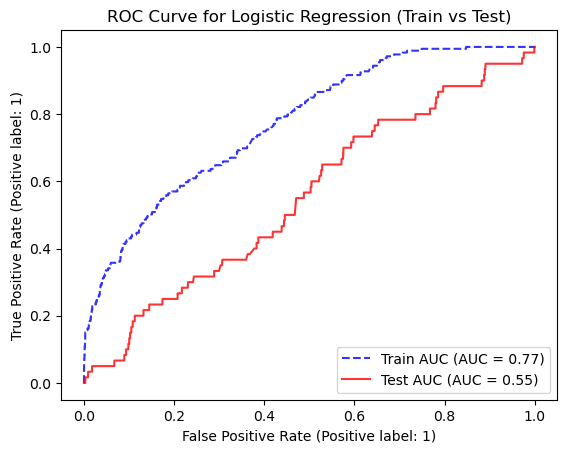

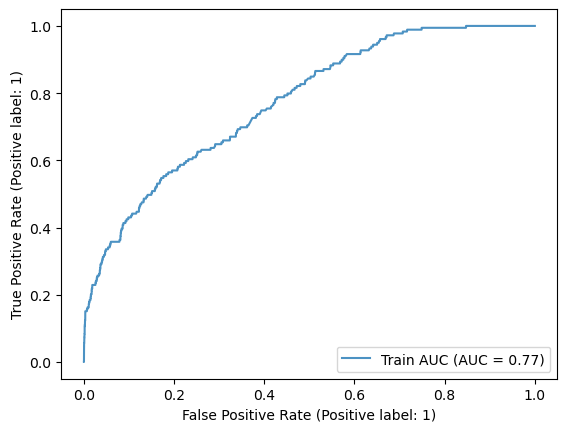

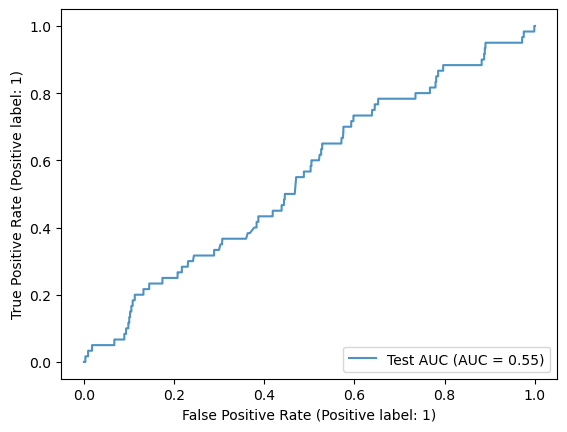

In [29]:
import matplotlib.pyplot as plt
from sklearn import metrics
ax = plt.gca()
ax.set_title("ROC Curve for Logistic Regression (Train vs Test)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
model_disp_train = metrics.RocCurveDisplay.from_estimator(model, data_train, outcomes_train, name='Train AUC', alpha=0.8)
model_disp_test = metrics.RocCurveDisplay.from_estimator(model, data_test, outcomes_test, name='Test AUC', alpha=0.8)

model_disp_train.plot(ax=ax, alpha=0.8, linestyle='--', color='blue')
model_disp_test.plot(ax=ax, alpha=0.8, linestyle='-', color='red')

plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight') 
plt.show()

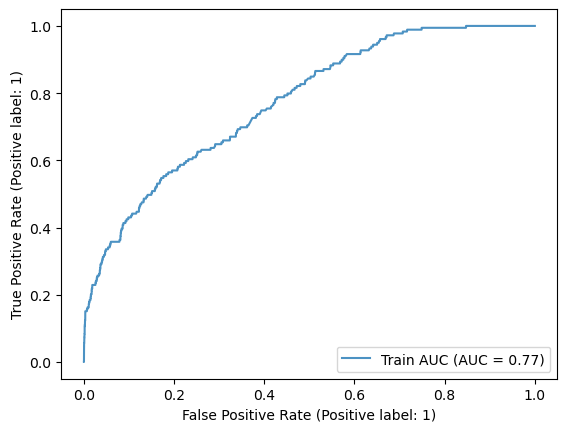

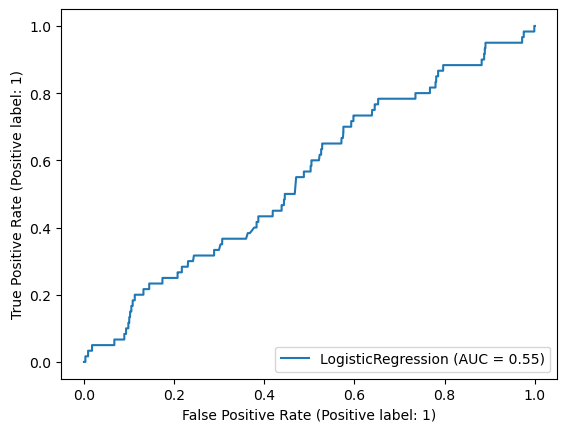

In [30]:
ax = plt.gca()
model_disp_test = metrics.RocCurveDisplay.from_estimator(model, data_test, outcomes_test)
model_disp_train.plot(ax=ax, alpha=0.8)

In [31]:
max(y_prob_train[:,1])

0.15155264597048695

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(outcomes_train, y_pred_train)

0.998443992419896

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(outcomes_test, y_pred_test)

0.9984353404438417

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(outcomes_train, y_pred_train).ravel()

array([114859,      0,    179,      0], dtype=int64)

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(outcomes_test, y_pred_test).ravel()

array([38287,     0,    60,     0], dtype=int64)

In [43]:
model = GaussianNB()

In [44]:
# Fit model on train data
model.fit(data_train, outcomes_train)



# Get train probabilities
y_prob_train = model.predict_proba(data_train)

y_pred_train = model.predict(data_train)

# Get the train auc score
train_auc = roc_auc_score(outcomes_train, y_prob_train[:, 1])
print(train_auc)

# Get test probabilities
y_prob_test = model.predict_proba(data_test)

y_pred_test = model.predict(data_test)

# Get the test auc score
test_auc = roc_auc_score(outcomes_test, y_prob_test[:, 1])
print(test_auc)

# Calculate precision-recall curve
precision_test, recall_test, _ = precision_recall_curve(outcomes_test, y_prob_test[:, 1])

# Calculate AUPRC
auprc_test_score = auc(recall_test, precision_test)

0.660218180551807
0.5088136965549664
